# Anomaly Detection - Outliers

---
## Point anomalies on test responding

It is mainly important to analyze all the features involved in every test taken by a person, and it is straightforward thinking that not all tasks are with full concentration because the nature of the tool, is an app, and we might expect the people taking the test can get distracted by some random reason.

The main objective here is to analyze any pattern related to the time in milliseconds a participant spend on responding to every visual task.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
color_ms = '#386cb0' #blue, This is the color chosen for patients with Multiple Sclerosis
color_hc = 'red'#This is the color chosen for health control participants

In [3]:
df_measures_users = pd.read_csv('https://s3.eu-west-3.amazonaws.com/pedrohserrano-datasets/df_measures_users.csv', encoding="utf-8")

In [4]:
df_symbols = pd.read_csv('https://s3.eu-west-3.amazonaws.com/pedrohserrano-datasets/df_symbols.csv', encoding="utf-8") 

In [5]:
score_variable = 'correct.answers'

### Population of Study

In [6]:
print('{} Data points distribuited among {} Participants'.format(len(df_symbols), len(df_measures_users)))

11420 Data points distribuited among 23 Participants


We choose the score variable as the number of correct answers on every test

In [7]:
#Split the patients MS (Multiple Sclerosis) and HC (Health Control)
df_ms = df_measures_users[df_measures_users['ms']==1]
df_hc = df_measures_users[df_measures_users['ms']==0]

In [10]:
print('Patients on Multiple Sclerosis group: {} ({}%)\nPatients on Health Control group: {} ({}%) '.format(
        len(df_ms), round(len(df_ms)/len(df_measures_users)*100, 0),
        len(df_hc), round(len(df_hc)/len(df_measures_users)*100, 0)))

Patients on Multiple Sclerosis group: 15 (65.0%)
Patients on Health Control group: 8 (35.0%) 


Text(0.5,1,'Scores Distribution Multiple Sclerosis and Health Control Groups')

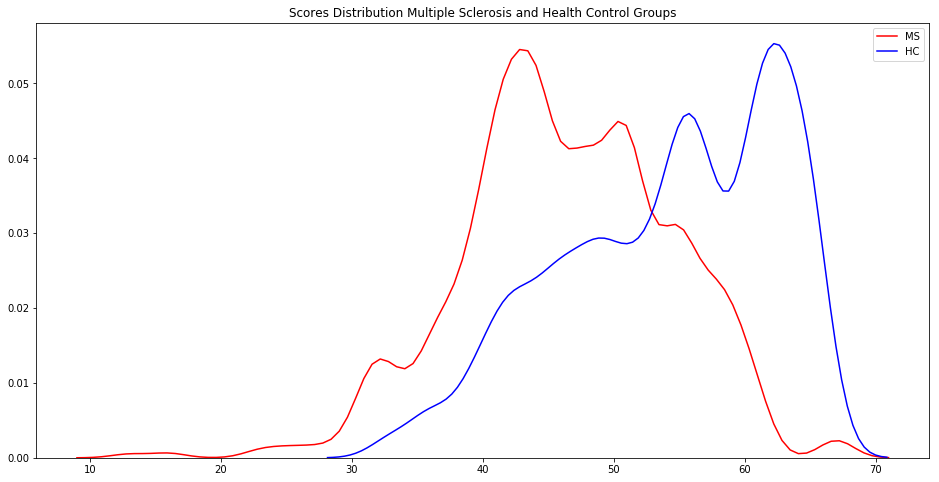

In [12]:
plt.figure(figsize=[16, 8])
sns.kdeplot(df_symbols[df_symbols['ms']==1][score_variable], color='red', label='MS')
sns.kdeplot(df_symbols[df_symbols['ms']==0][score_variable], color='blue', label='HC')
plt.title('Scores Distribution Multiple Sclerosis and Health Control Groups')

---
### Defining Boundary

The first thing we have to consider is the time.

So we define $ \Delta_{tr} $ as the time elapsed between 2 trials, where a trial is the event of push the button and select a digit on the test.

Thinking on this, we say that every person perform $n$ number of tests and every test has $m$ number of trials, then the time elapsed to perform every trial is $ \Delta_{tr} $

We define $T$ as the vector of time responses on an event, following this logic we can calculate the median of those times.

Finally we may calculate the $SD$ of all the people on MS and Health Control group separately.

##### Distraction Points

$$ \Delta_{tr} > median(T) + 2 (SD (Group))  \hspace{1cm} $$
$$ \max{\{\Delta_{tr},0\}} < median(T) - 2 (SD (Group))  \hspace{1cm} \forall{\Delta_{tr}}$$

$T =(\Delta_{tr1}, \Delta_{tr2}, ... \Delta_{trm})$  
$tr =$ Time of response on a trial

In [13]:
print('Standard Deviation of every delta per group \n MS: {} \n Health Control: {}'.format(
df_symbols['response_ms_sd'].unique()[0], df_symbols['response_ms_sd'].unique()[1]))

Standart Deviation of every delta per group 
 MS: 663.6751885085198 
 Health Control: 502.5068924690813


### Detecting Outliers

We can just take one single event on a randomly chosen person (eobt3CosDzEtxWW5P) for instance, and plot the time of response in milisecond alongside the 90 seconds showing the symbols chosen on each task

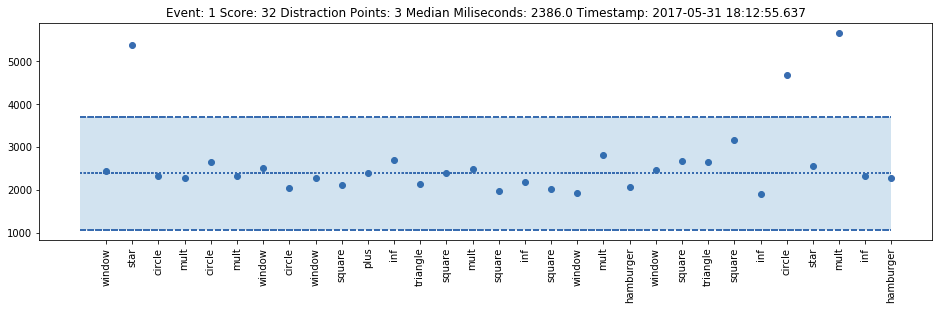

In [14]:
df_user = df_symbols[df_symbols['userId']=='eobt3CosDzEtxWW5P']
stamps = df_user['timestamp'].unique()

plt.figure(figsize=(16, 4))
df_user_ts = df_user[df_user['timestamp']==stamps[0]]
plt.scatter(df_user_ts['trial'], df_user_ts['response_ms'], color=color_ms)
plt.hlines(y=df_user_ts['sup_line'], xmin=0, xmax=max(df_user_ts['trial']), linestyles='--', color=color_ms)
plt.hlines(y=df_user_ts['inf_line'], xmin=0, xmax=max(df_user_ts['trial']), linestyles='--', color=color_ms)
plt.hlines(y=df_user_ts['response_ms_med'], xmin=0, xmax=max(df_user_ts['trial']), linestyles=':', color=color_ms)
plt.fill_between(range(len(df_user_ts['trial'])+1), df_user_ts['sup_line'].mean(), df_user_ts['inf_line'].mean(), alpha=0.2)
plt.xticks(df_user_ts['trial'], df_user_ts['symbol'], rotation=90)
grouped = df_symbols.groupby(['userId','timestamp'])['distract_points'].sum().reset_index()
d_point = grouped[(grouped['userId']=='eobt3CosDzEtxWW5P') & (grouped['timestamp']==stamps[0])]['distract_points'].values
plt.title('Event: 1 Score: '+str(max(df_user_ts['correct.answers']))+' Distraction Points: '+str(d_point[0])+' Median Miliseconds: '+str(df_user_ts['response_ms_med'].mean())+' Timestamp: '+str(stamps[0]))
plt.show()

As we might see the points outside of the boundaries are distraction points because they are 2 Standard Deviation of the median time of response, where the Standard Deviation corresponds the variance of the group.

The plot below shows the distribution of the time of response in milliseconds on this same event.

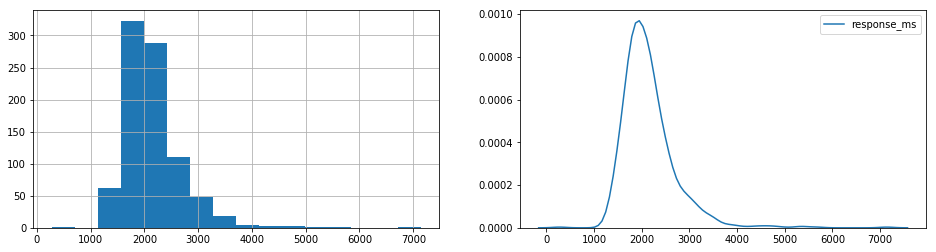

In [15]:
plt.figure(figsize=(16, 4))
plt.subplot(1,2,1)
df_user['response_ms'].hist(bins=16)
plt.subplot(1,2,2)
sns.kdeplot(df_user['response_ms'])

### Distraction Points Correlated

The first thing to check is the relation that distracting points have with the score performed on every individual, as we know each test has distraction points and scores, we might aggregate per groups, then we can compare if there is any difference between the number of distractions if a person is MS or HC

In [16]:
df_measures_users.groupby('ms').mean()

correct.answers  total.answers  accuracy.rate  avg_test_ms       hour  \
ms                                                                           
0.0        52.918429      53.447127       0.989380  3355.509615  14.208883   
1.0        46.223607      46.766710       0.986986  3827.878461  15.006200   

        events  correct.answers_median  distract_points  
ms                                                       
0.0   8.375000                 53.1875         1.811531  
1.0  11.933333                 46.6000         1.496902

The table below shows the distractions and scores on each group

| Group | Average Score | Average Distractions |
|:--:|:--:|:--:|
| MS | 52.91 | 1.81 |
| HC | 46.22 | 1.49 |

In [17]:
df_ms = df_measures_users[df_measures_users['ms']==1]
df_hc = df_measures_users[df_measures_users['ms']==0]

/home/dennis/.local/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


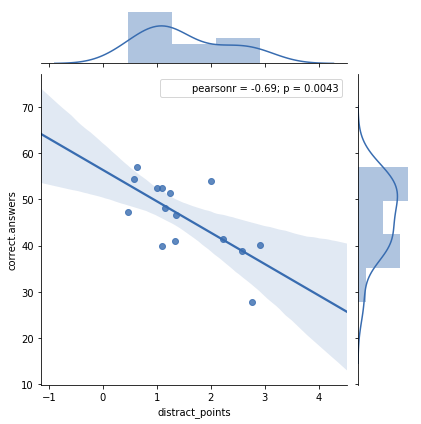

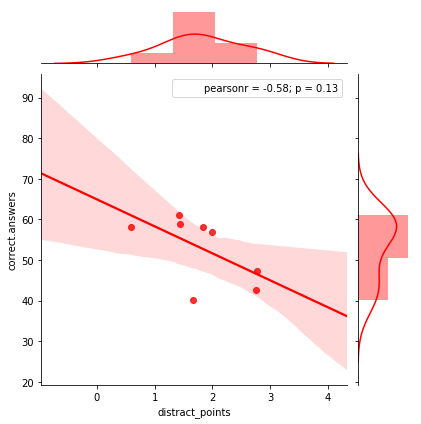

In [18]:
sns.jointplot("distract_points", "correct.answers", data=df_ms, kind="reg", color=color_ms) #MS correlation
sns.jointplot("distract_points", "correct.answers", data=df_hc, kind="reg", color=color_hc) #HC correlation

As we may see on the plots above we see a negative and significative correlation, the MS group is more clear.
**The more distractions the lower the score**

The number of distractions that a single person has is a clear feature that helps to classify the MS people, this feature does not depend on demographic variables but just with in the test behaviour

---
### Plotting All participants, All events

/home/dennis/.local/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


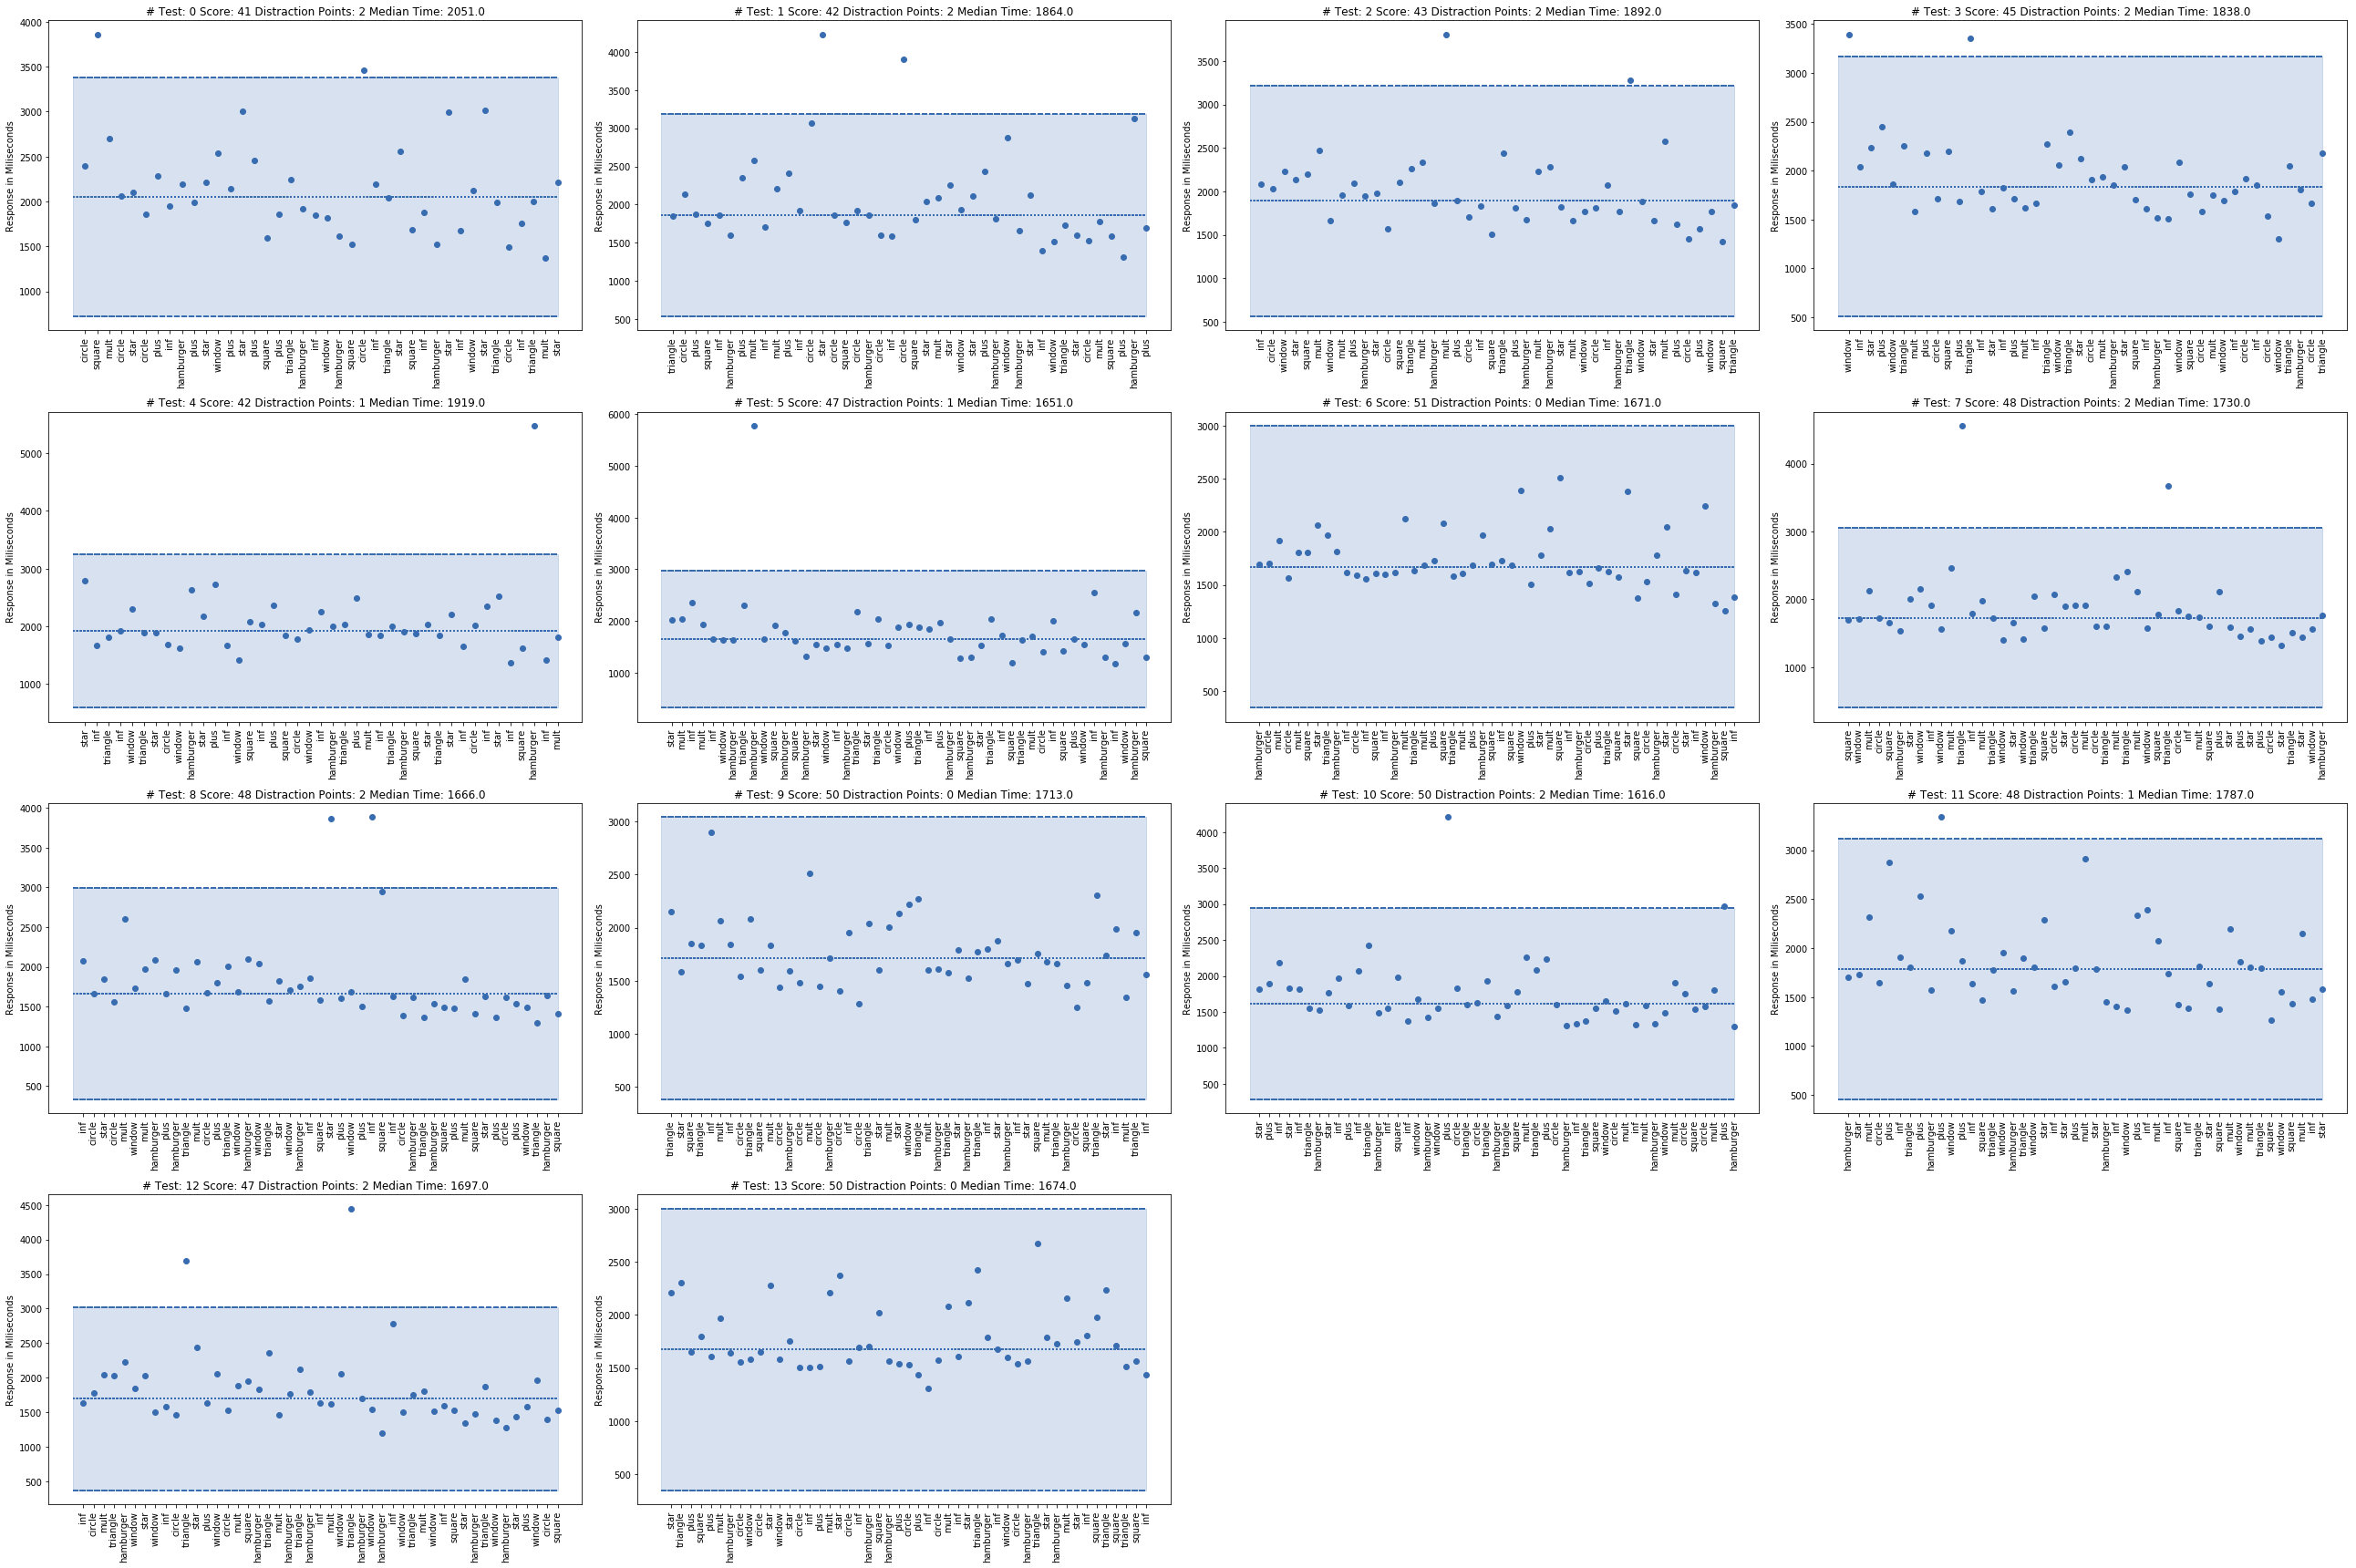

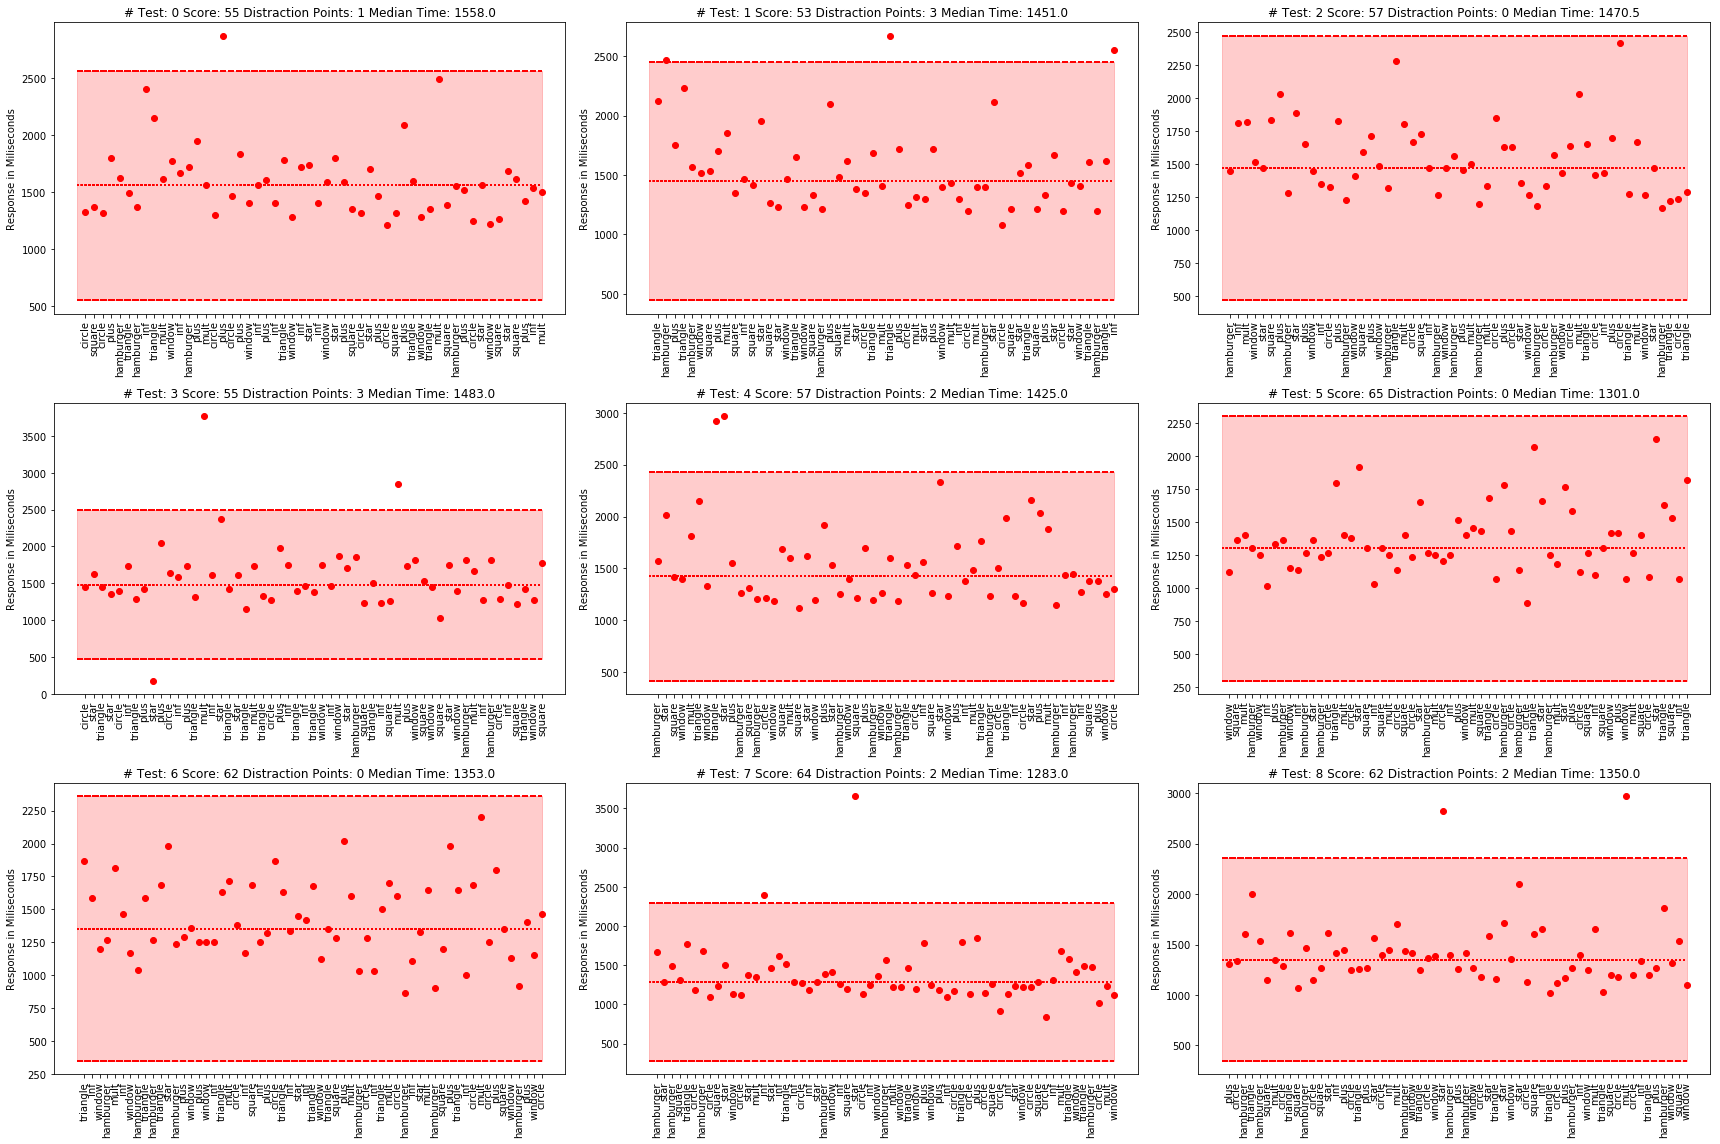

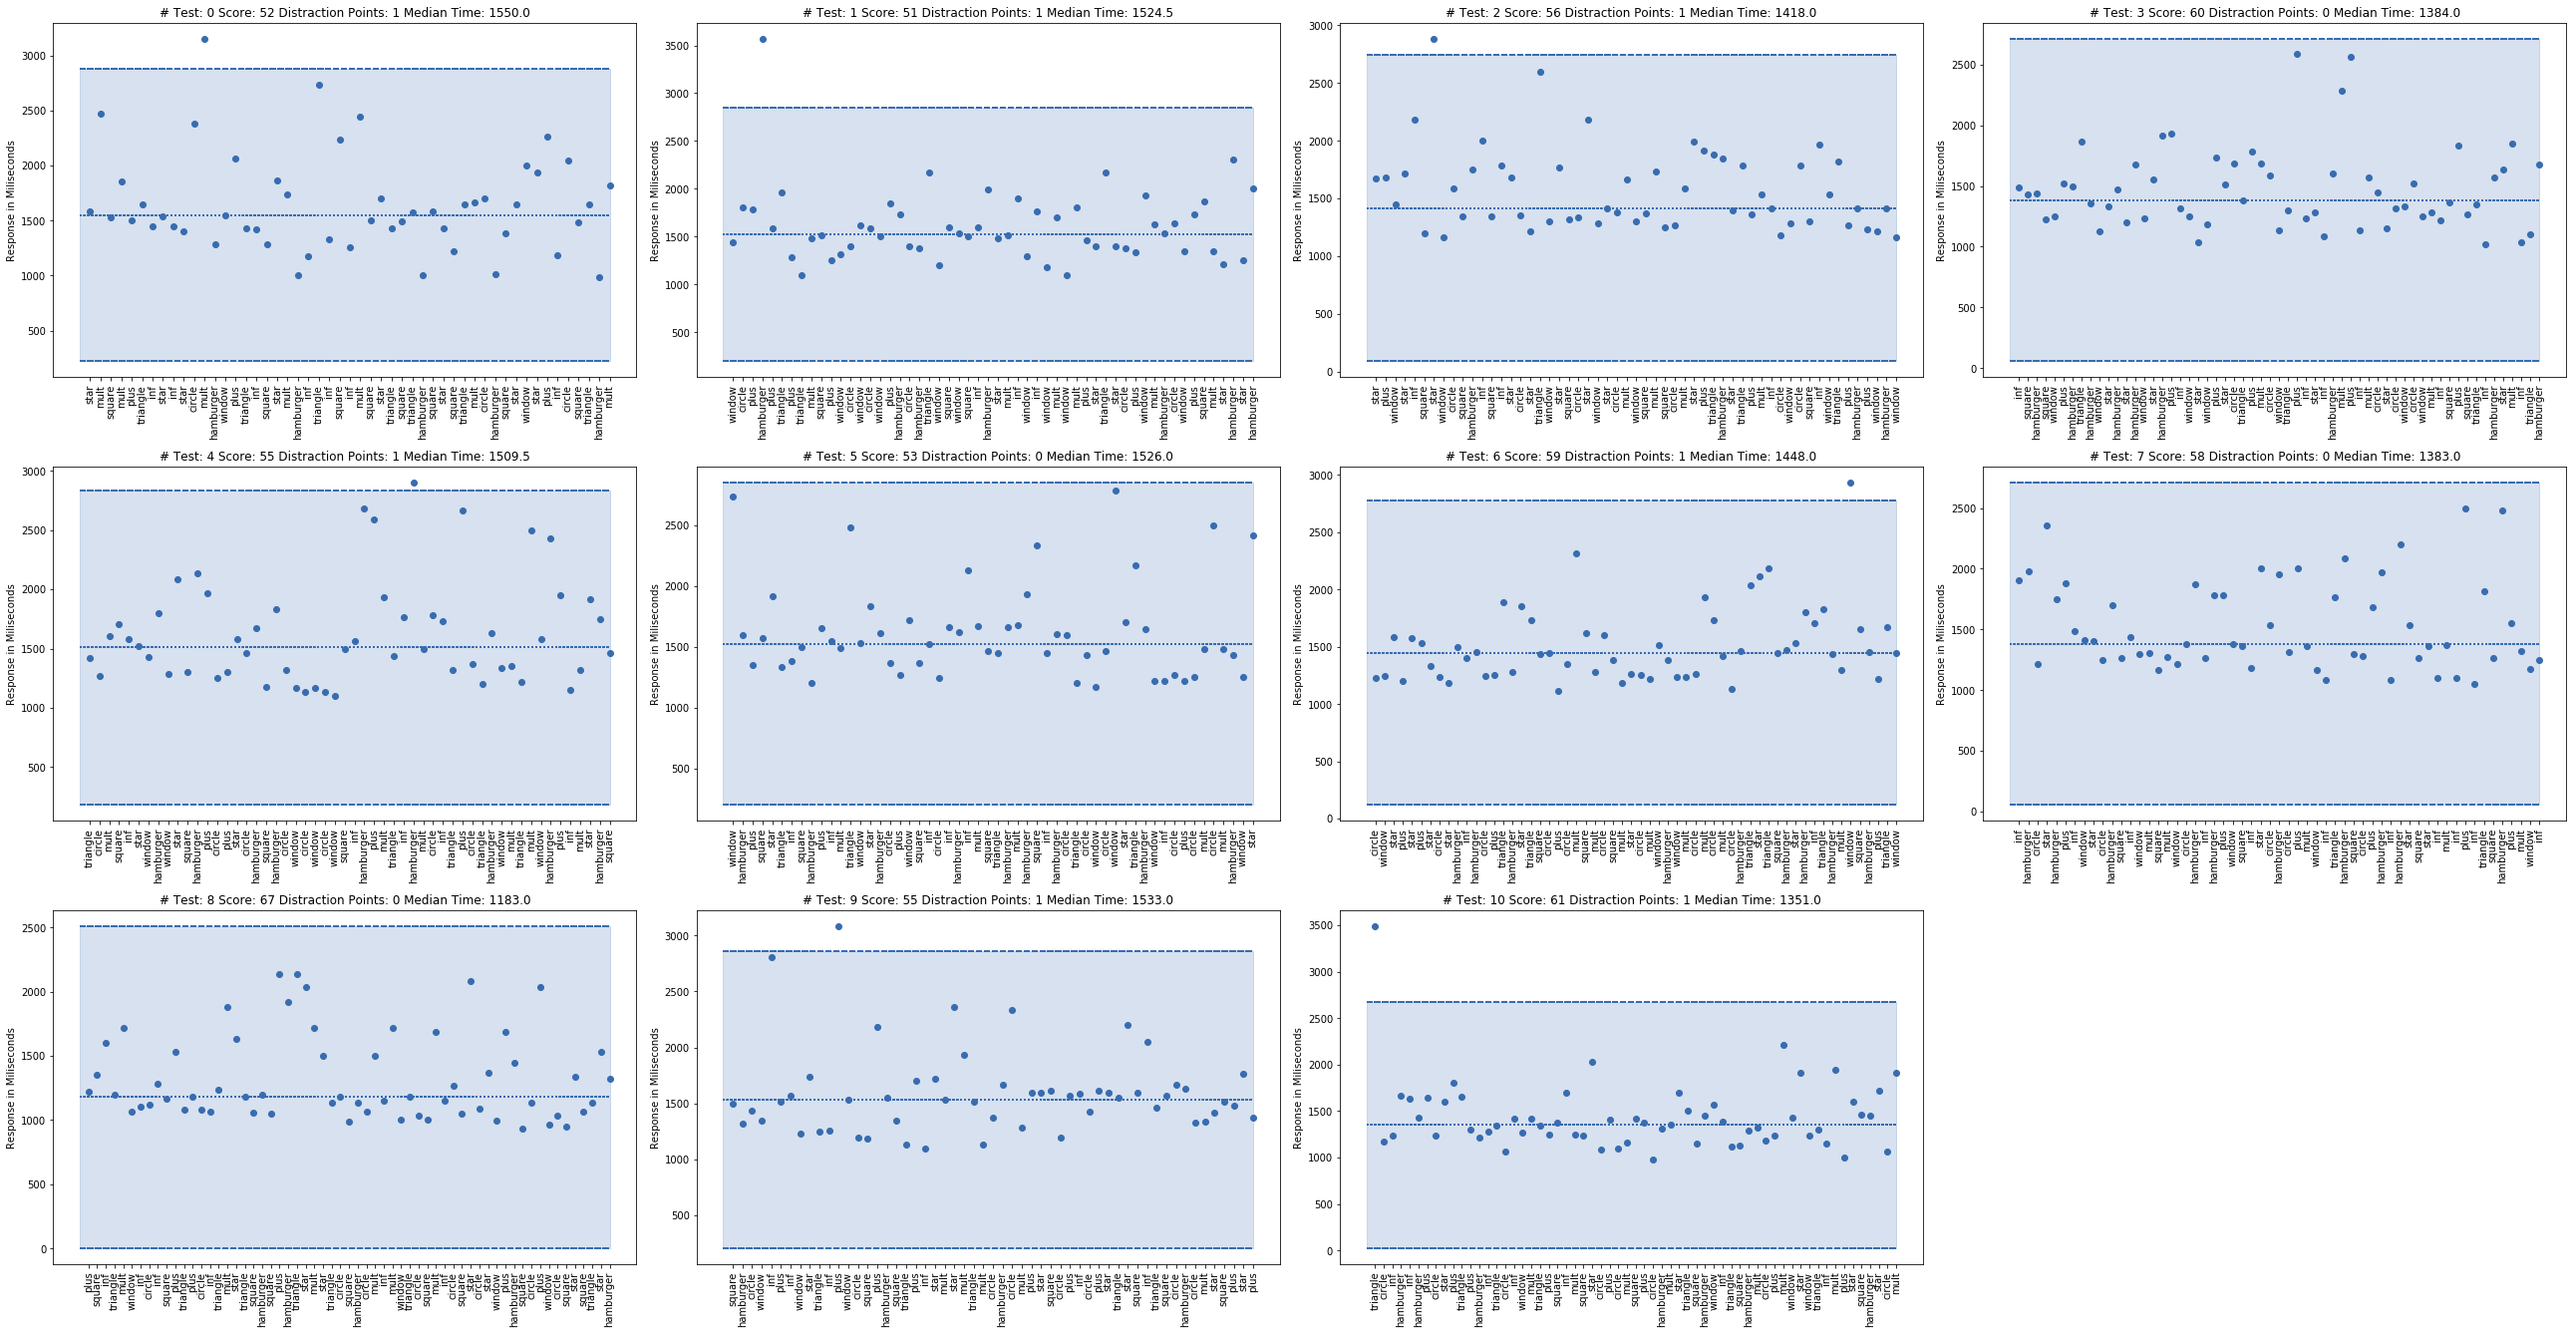

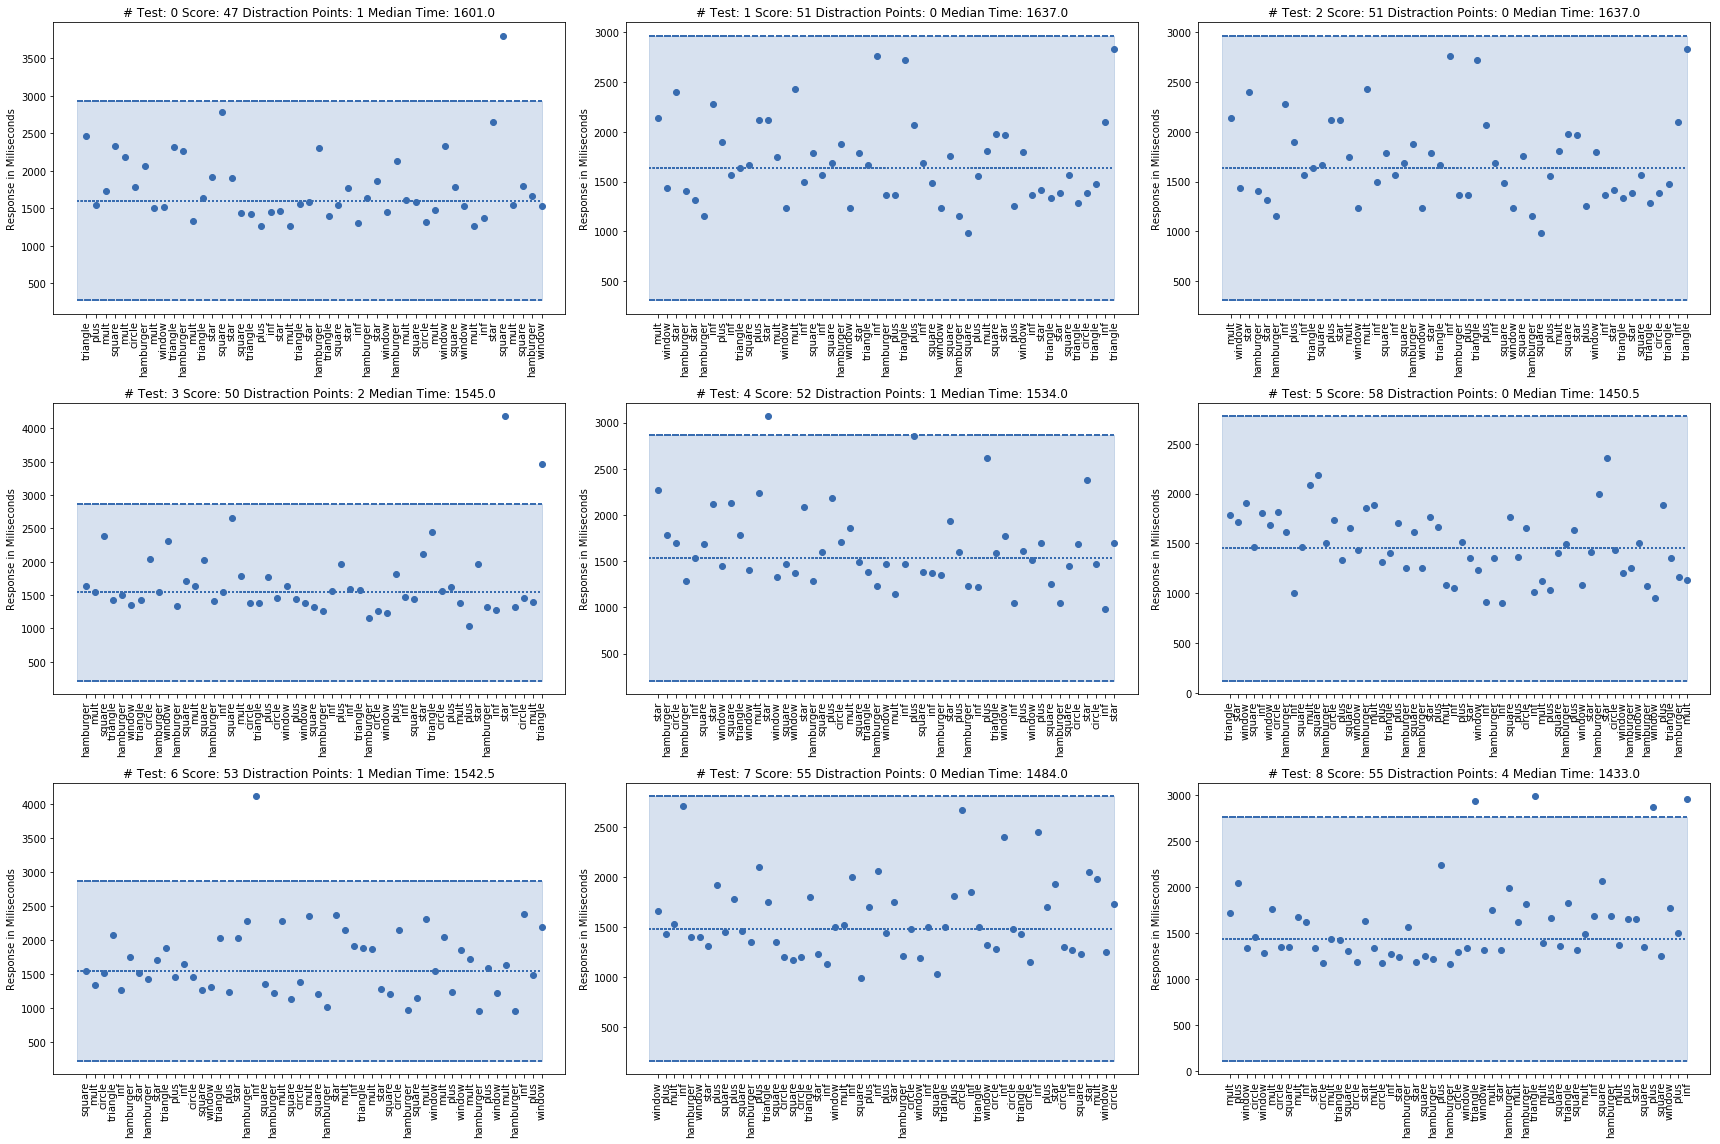

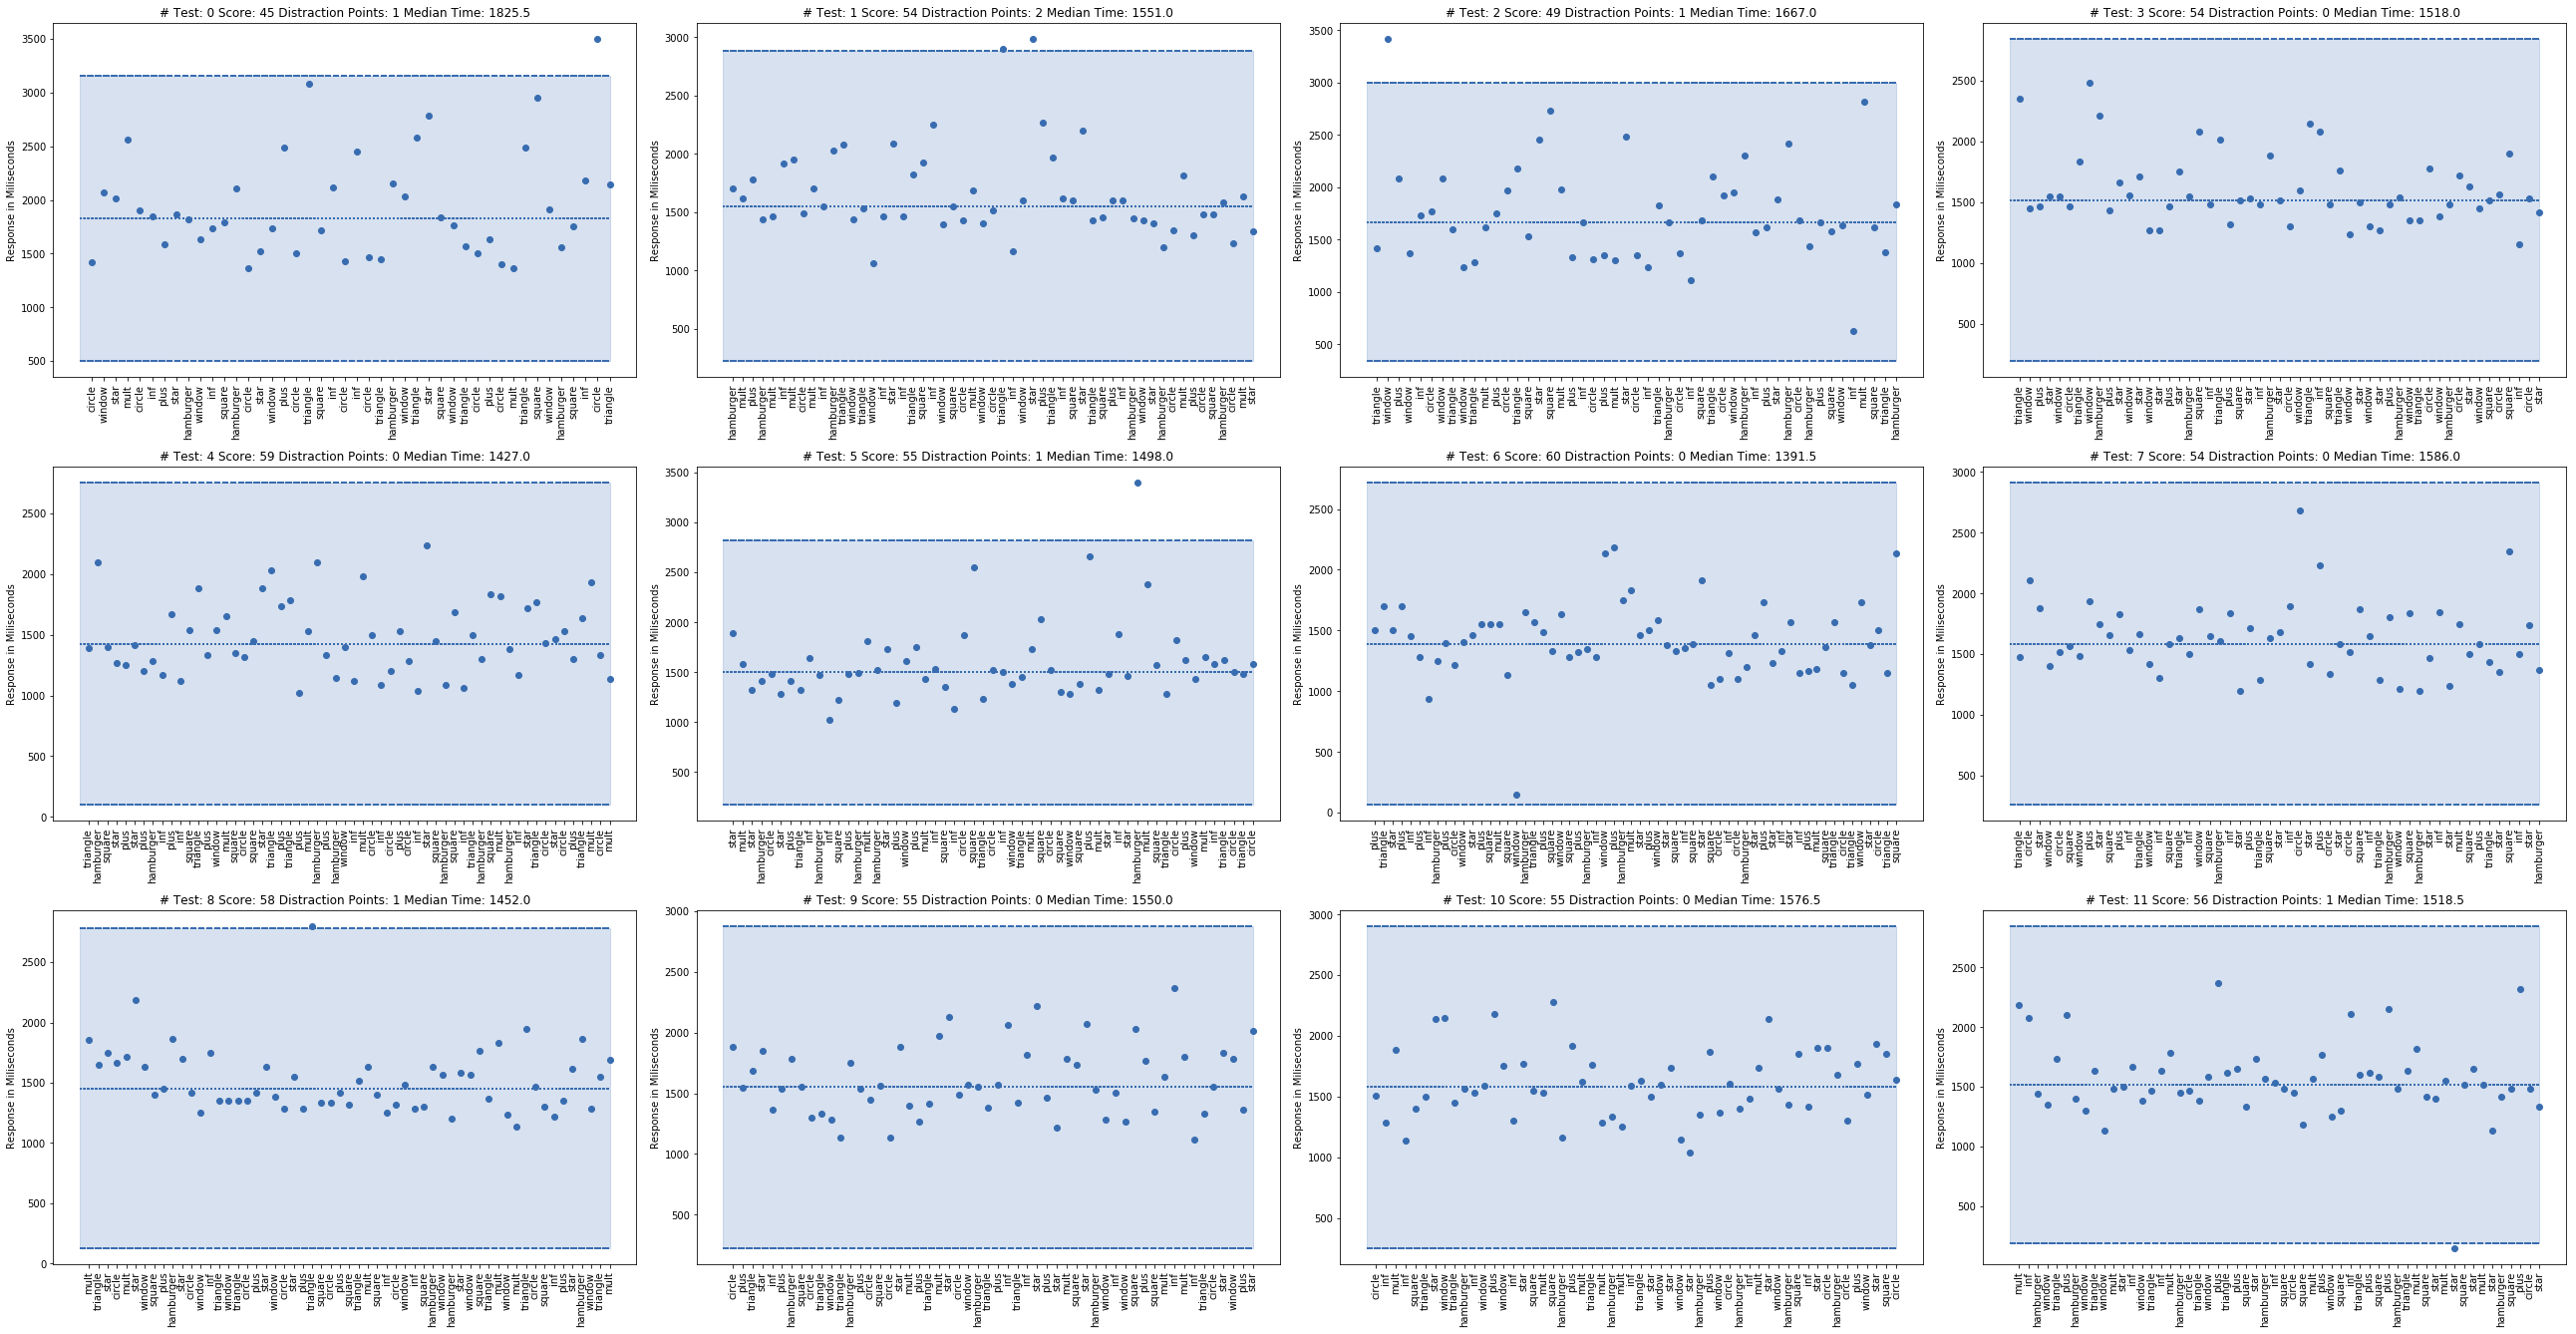

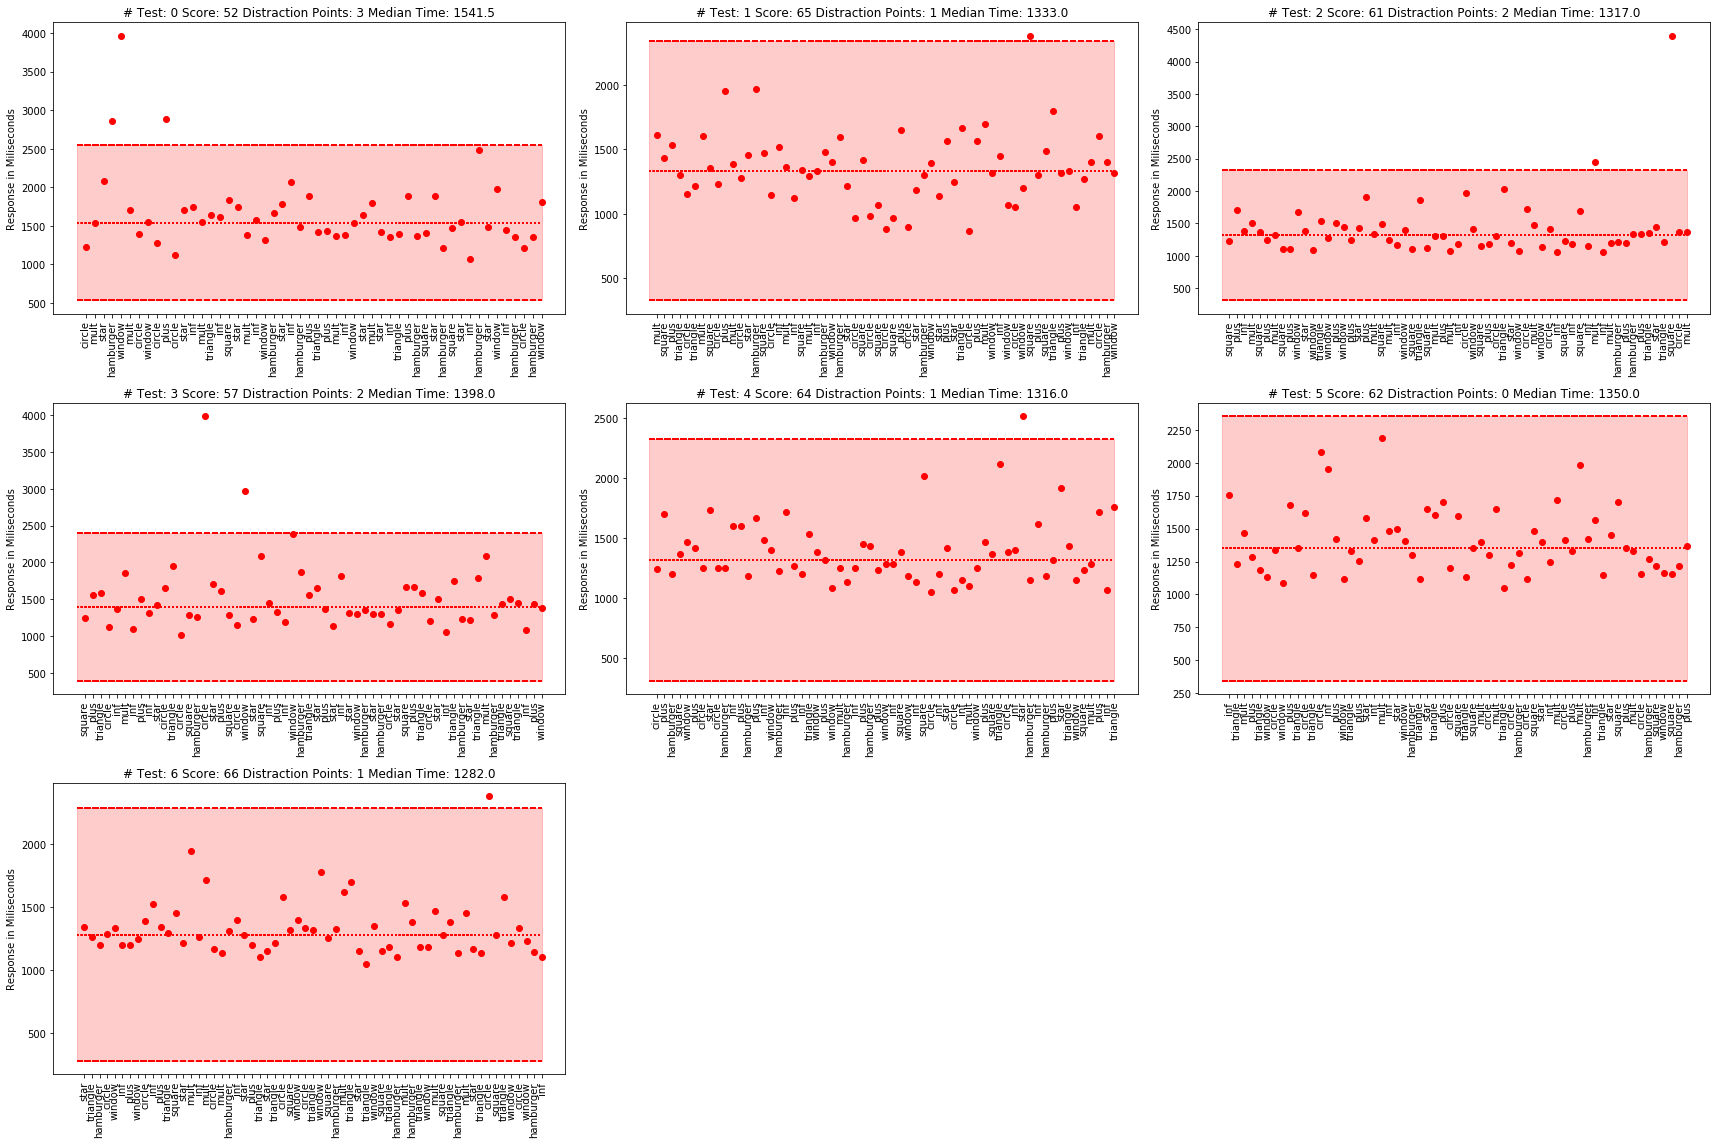

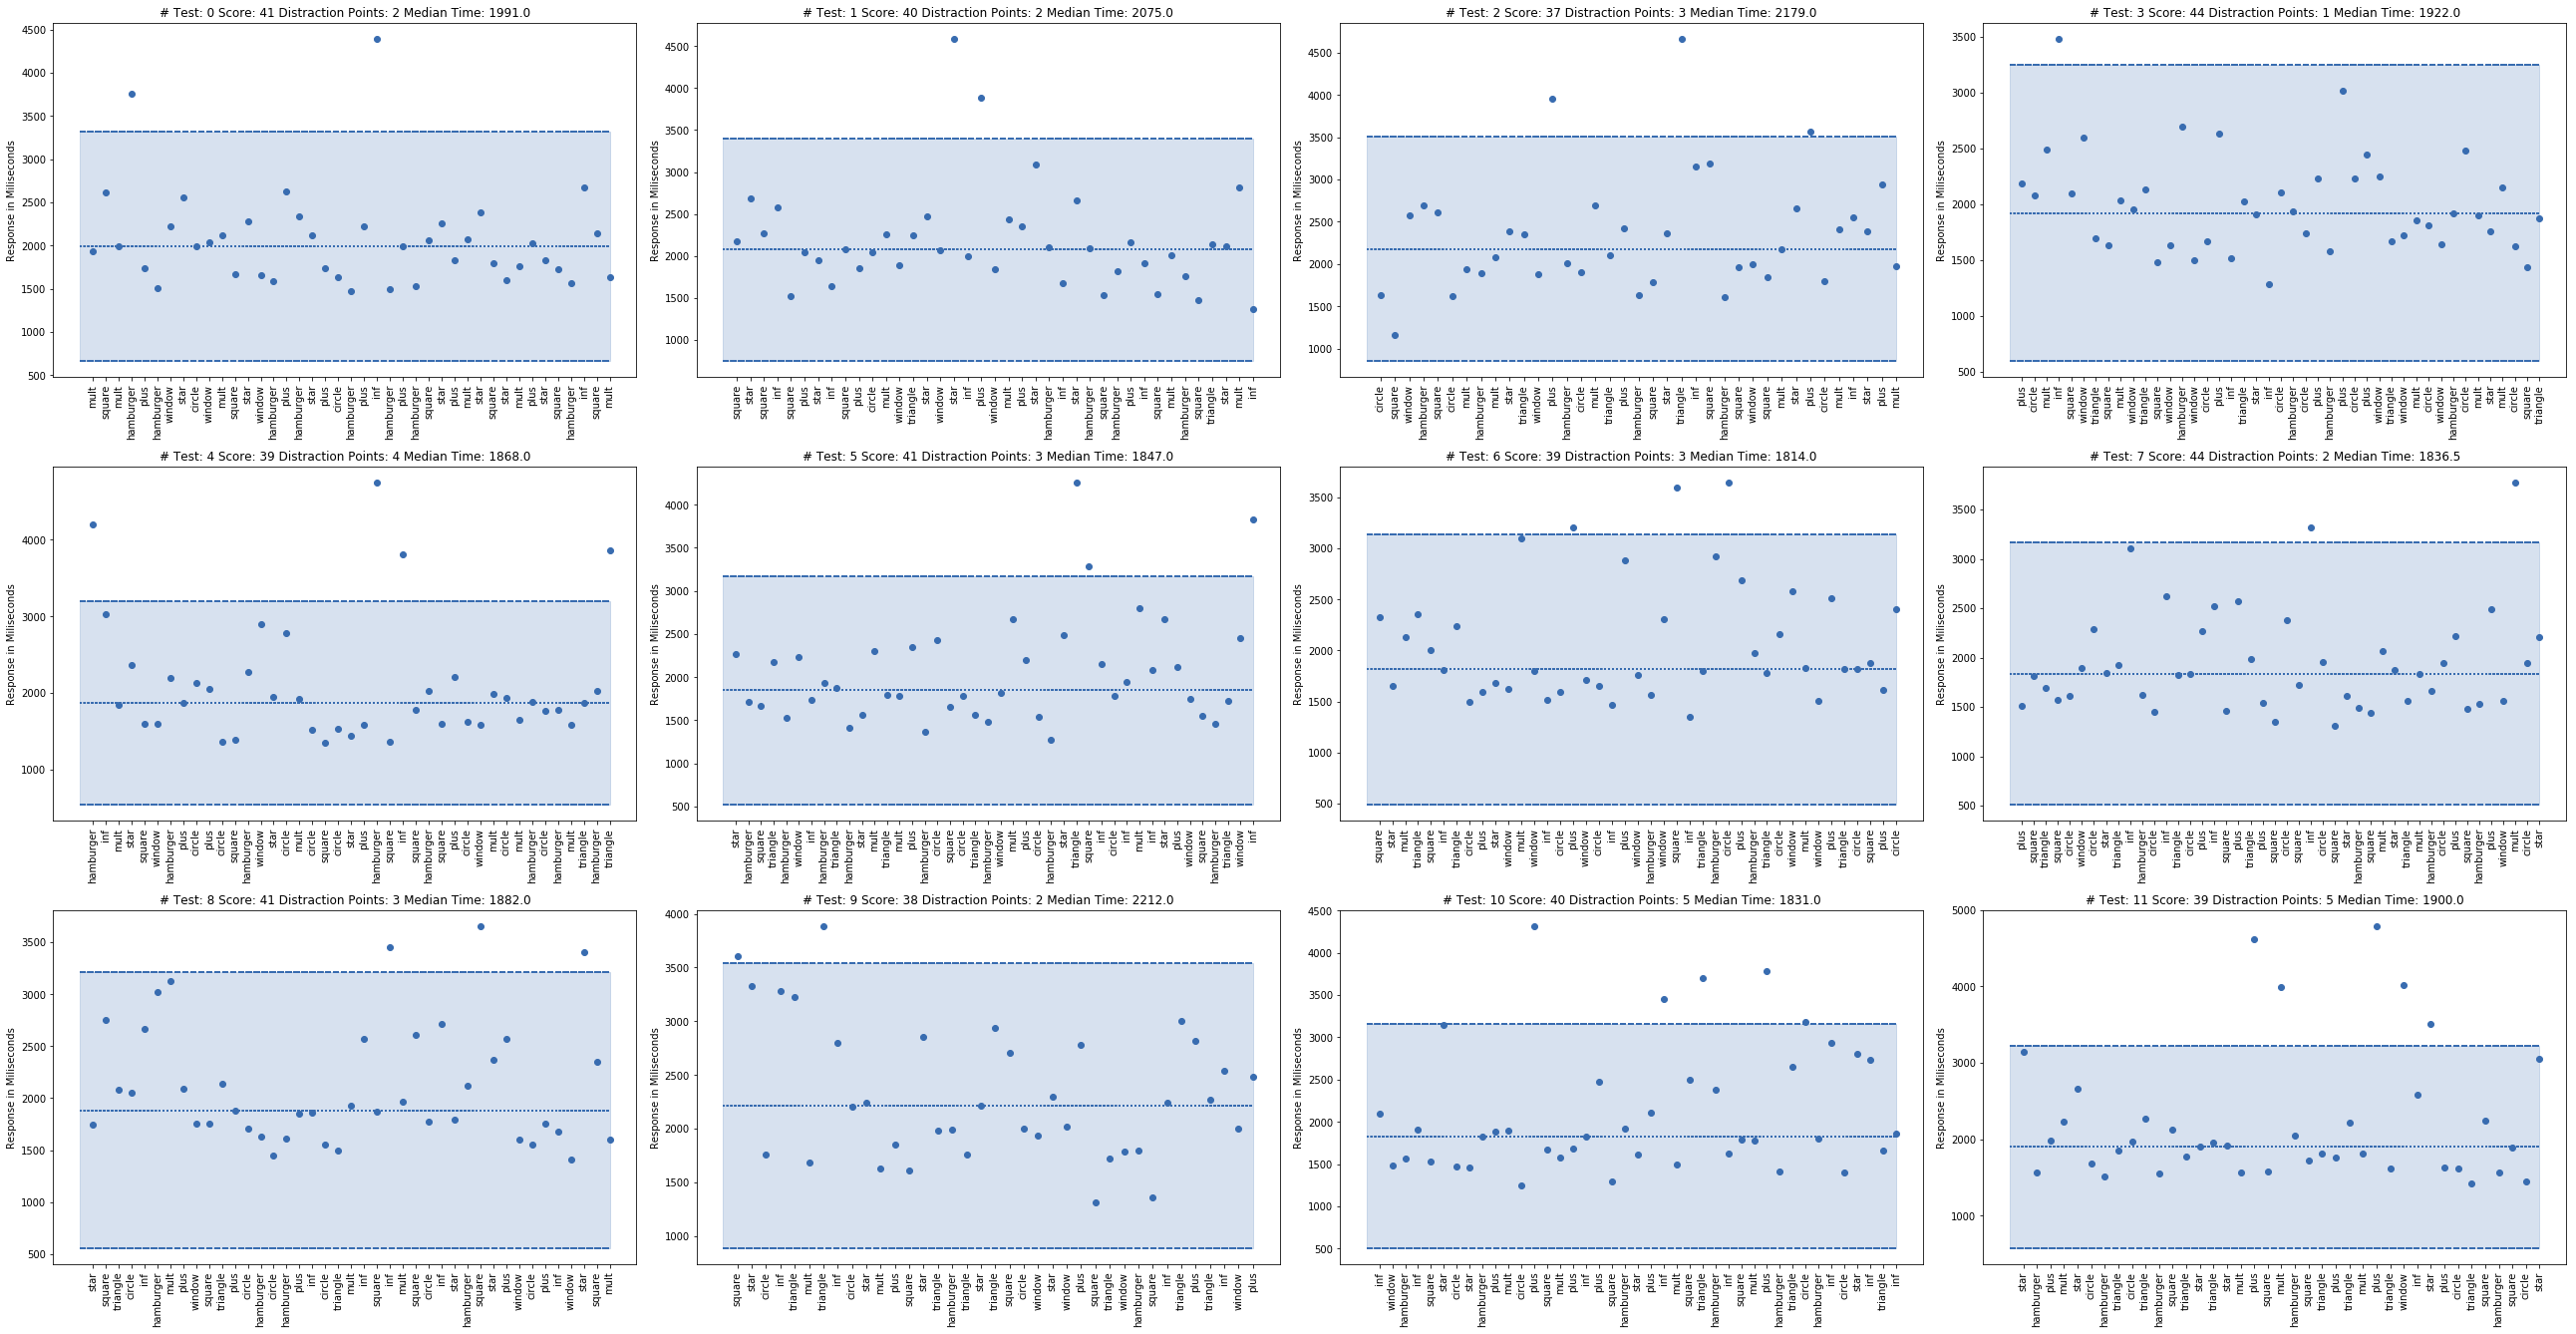

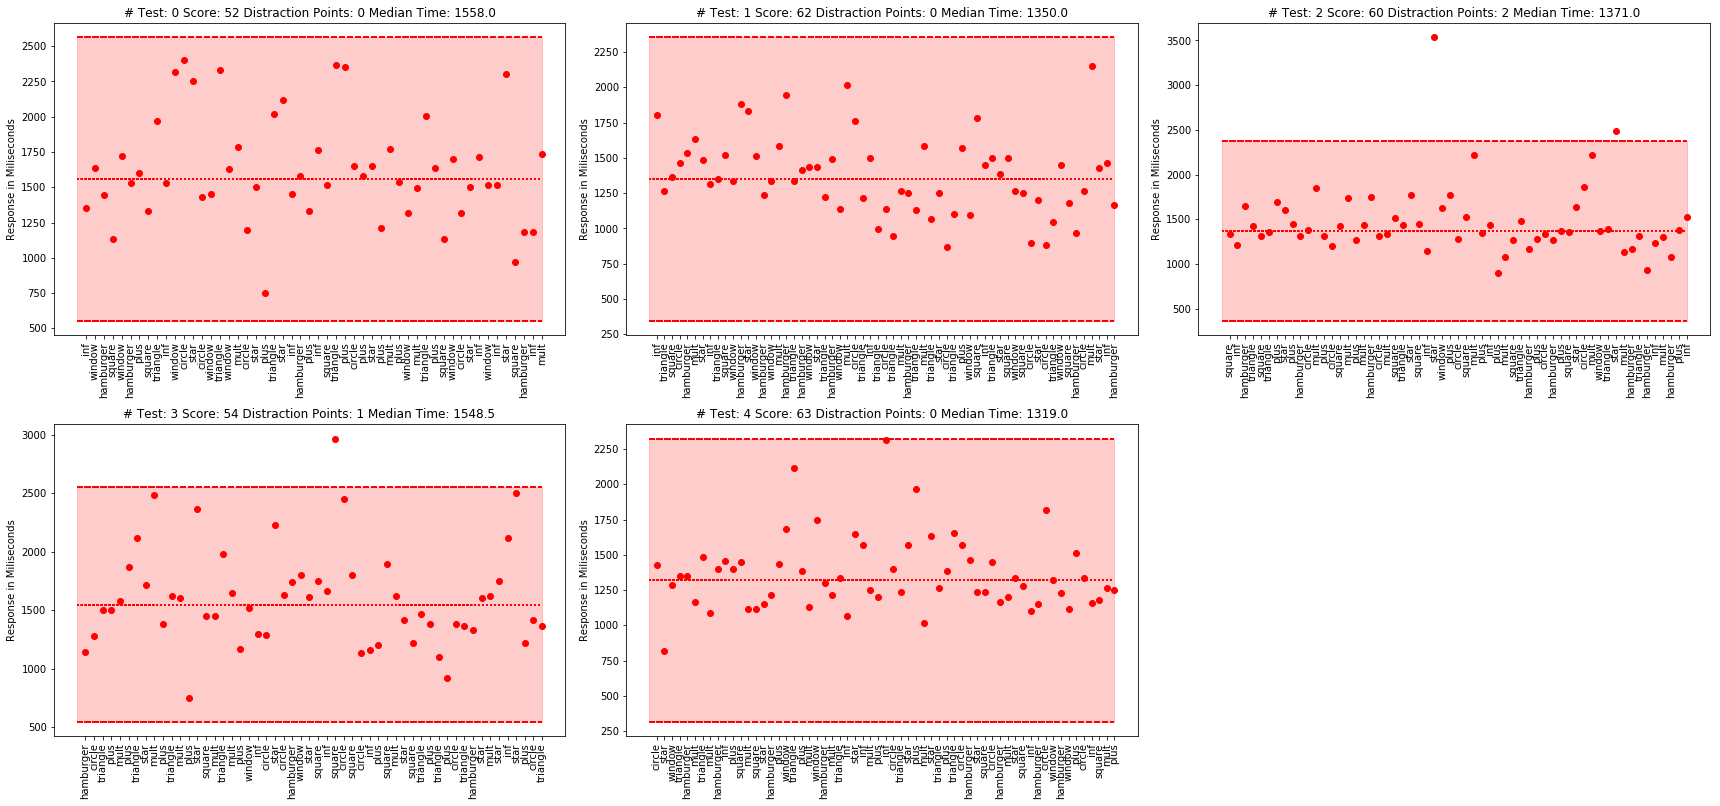

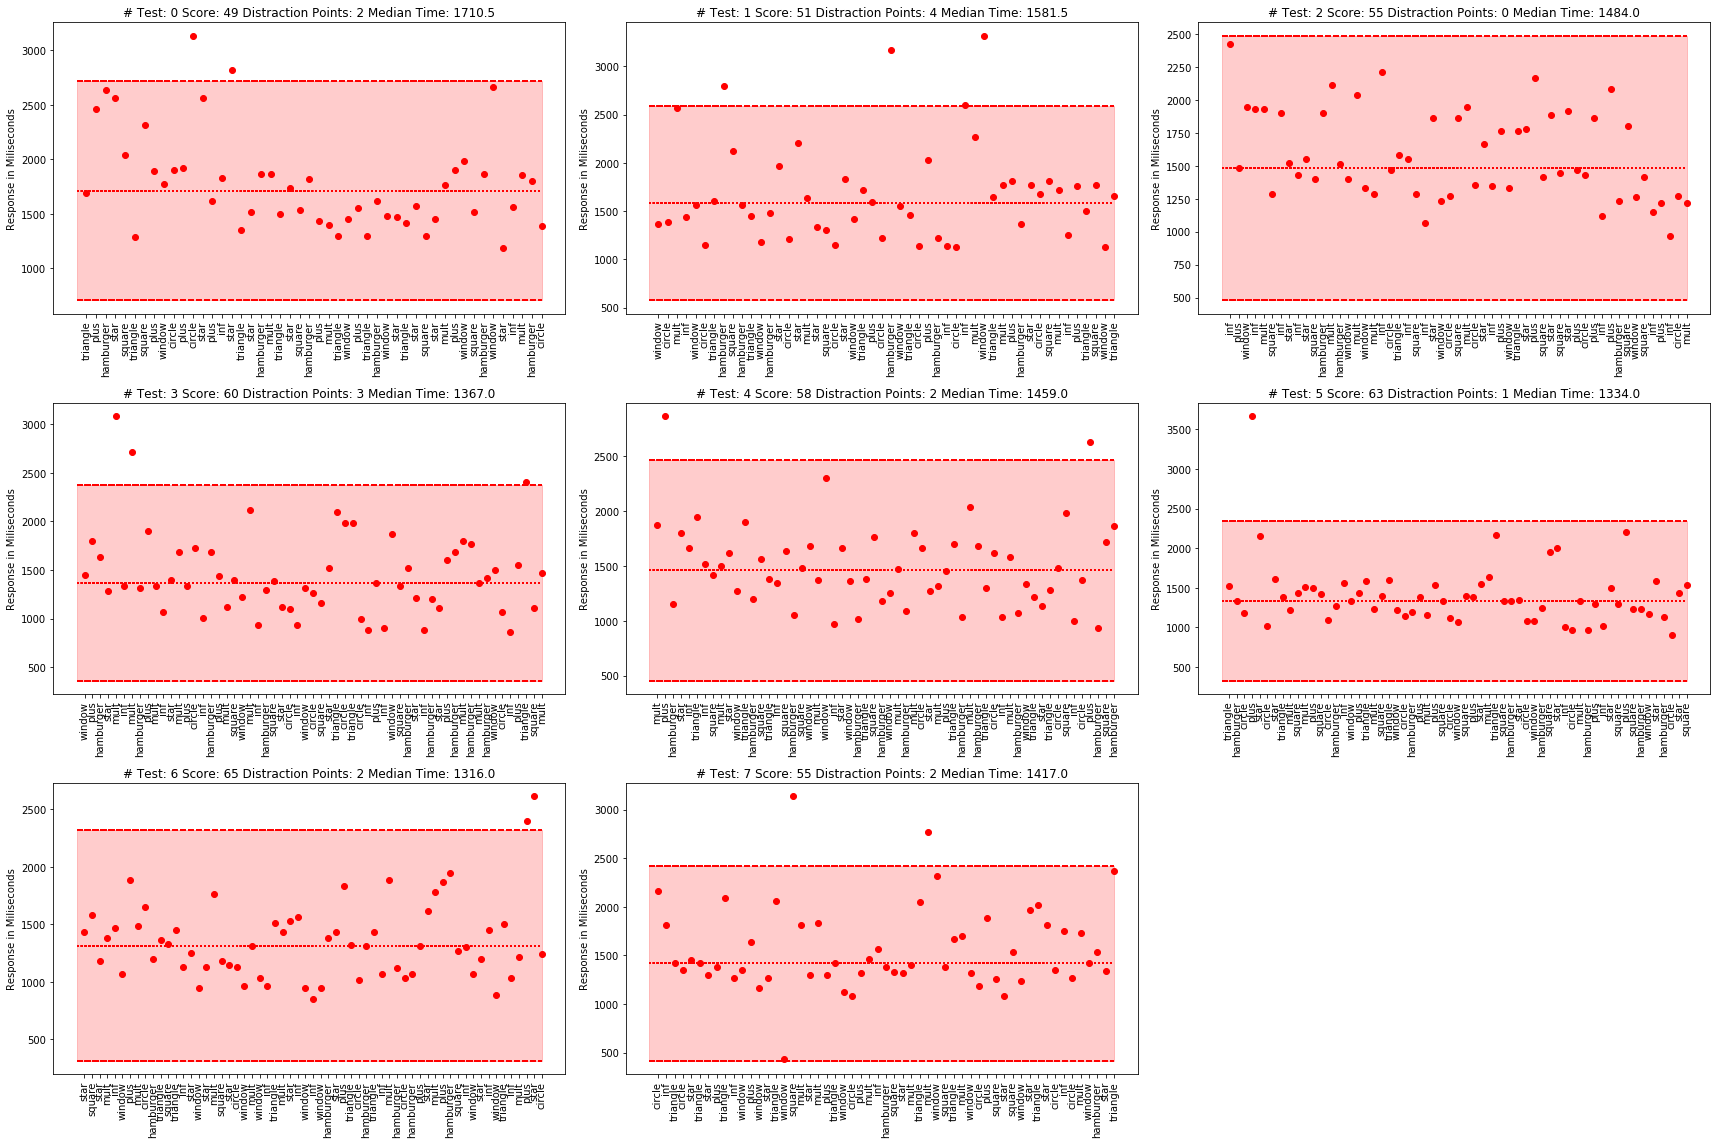

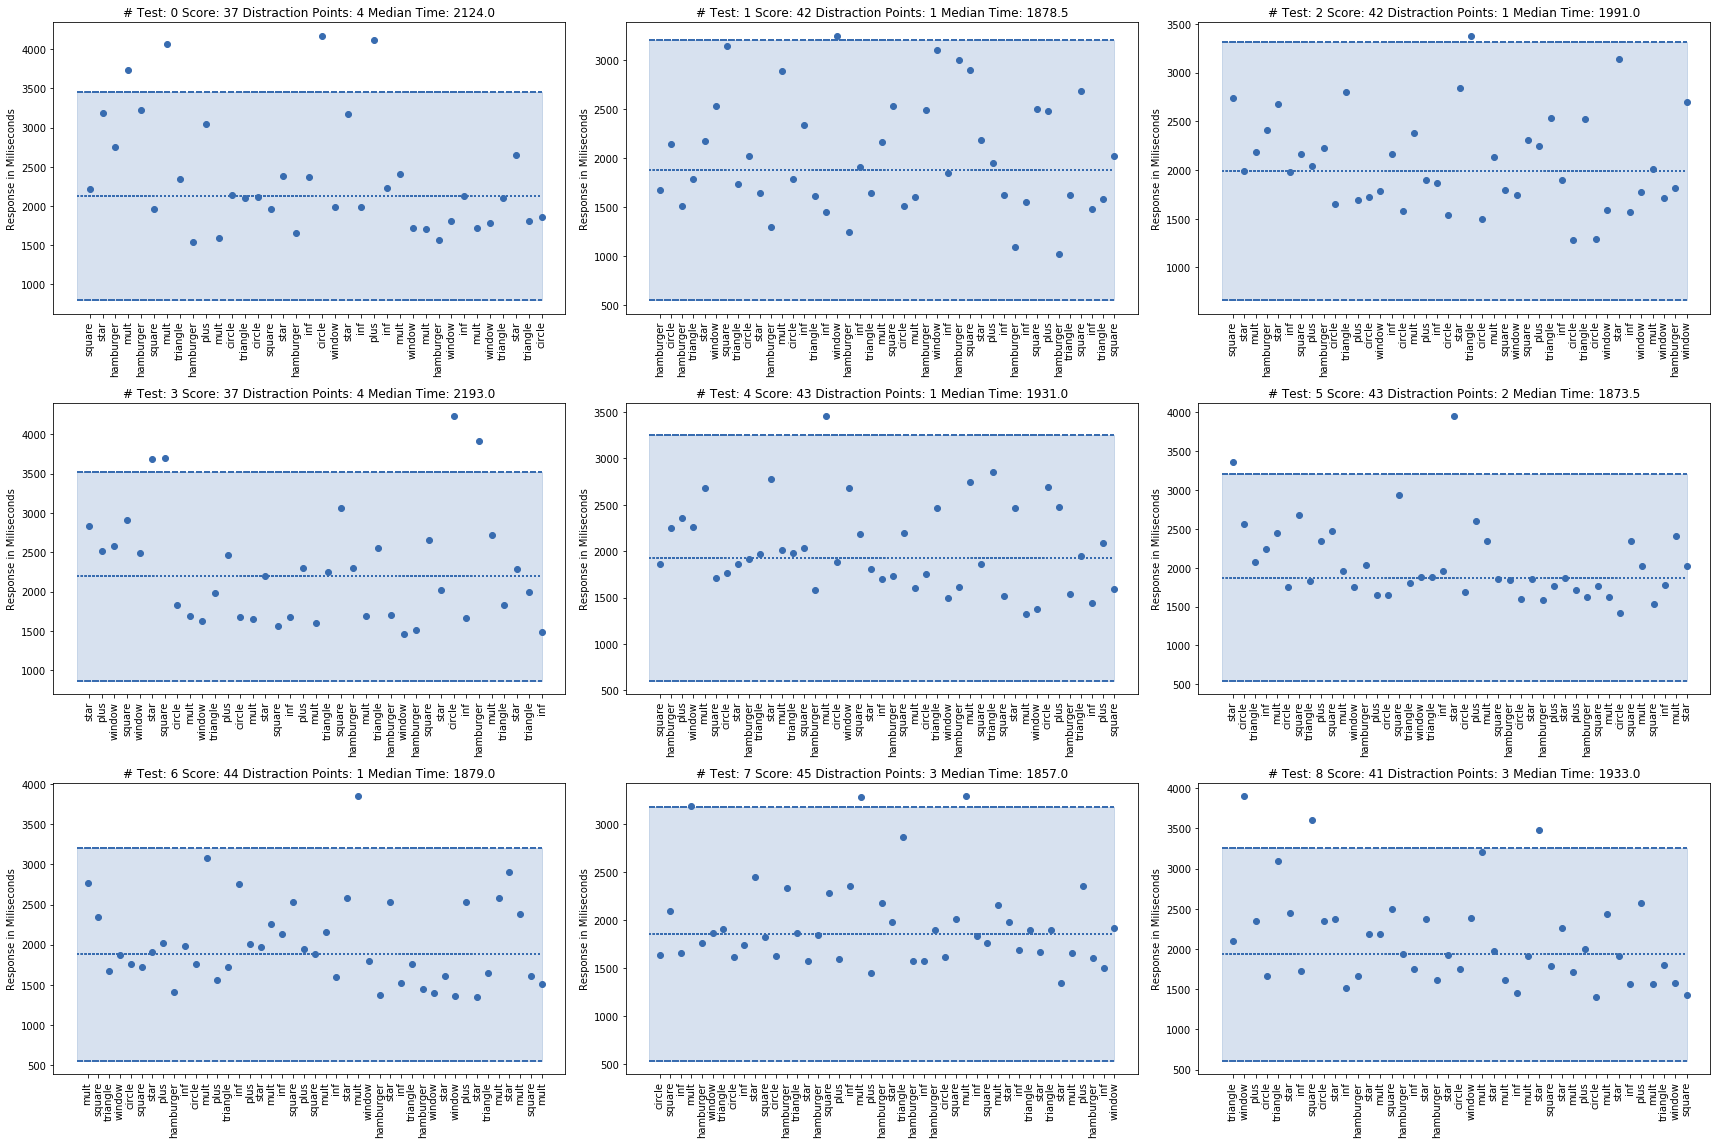

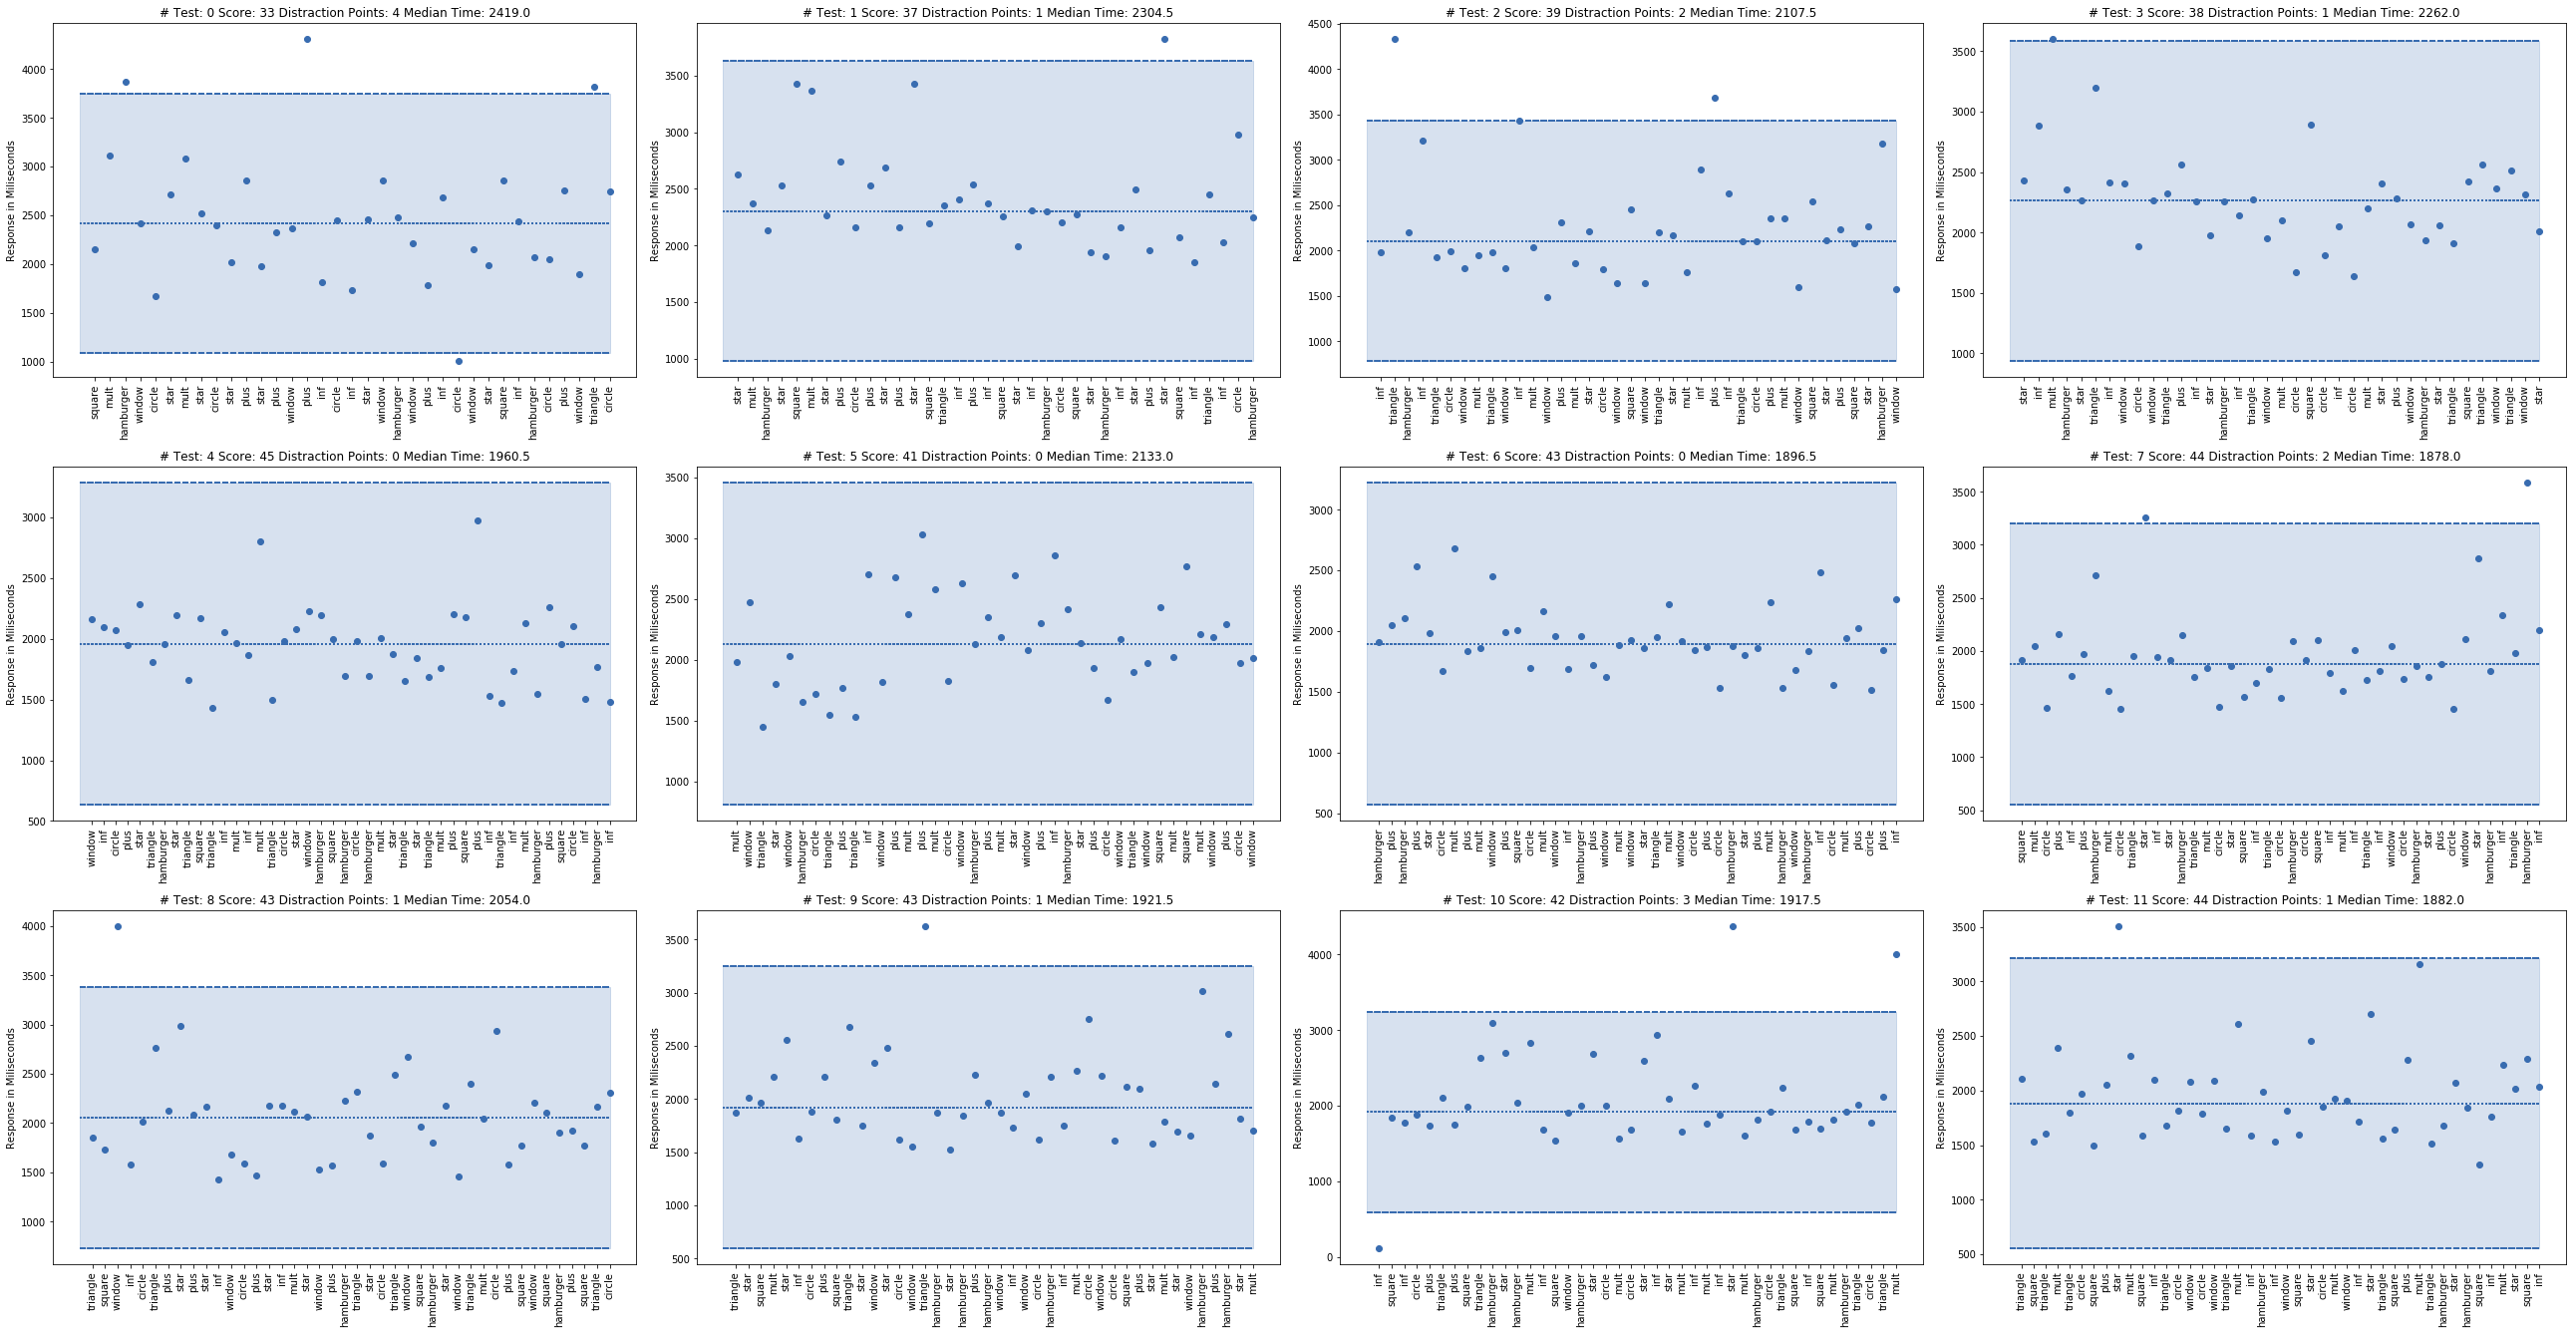

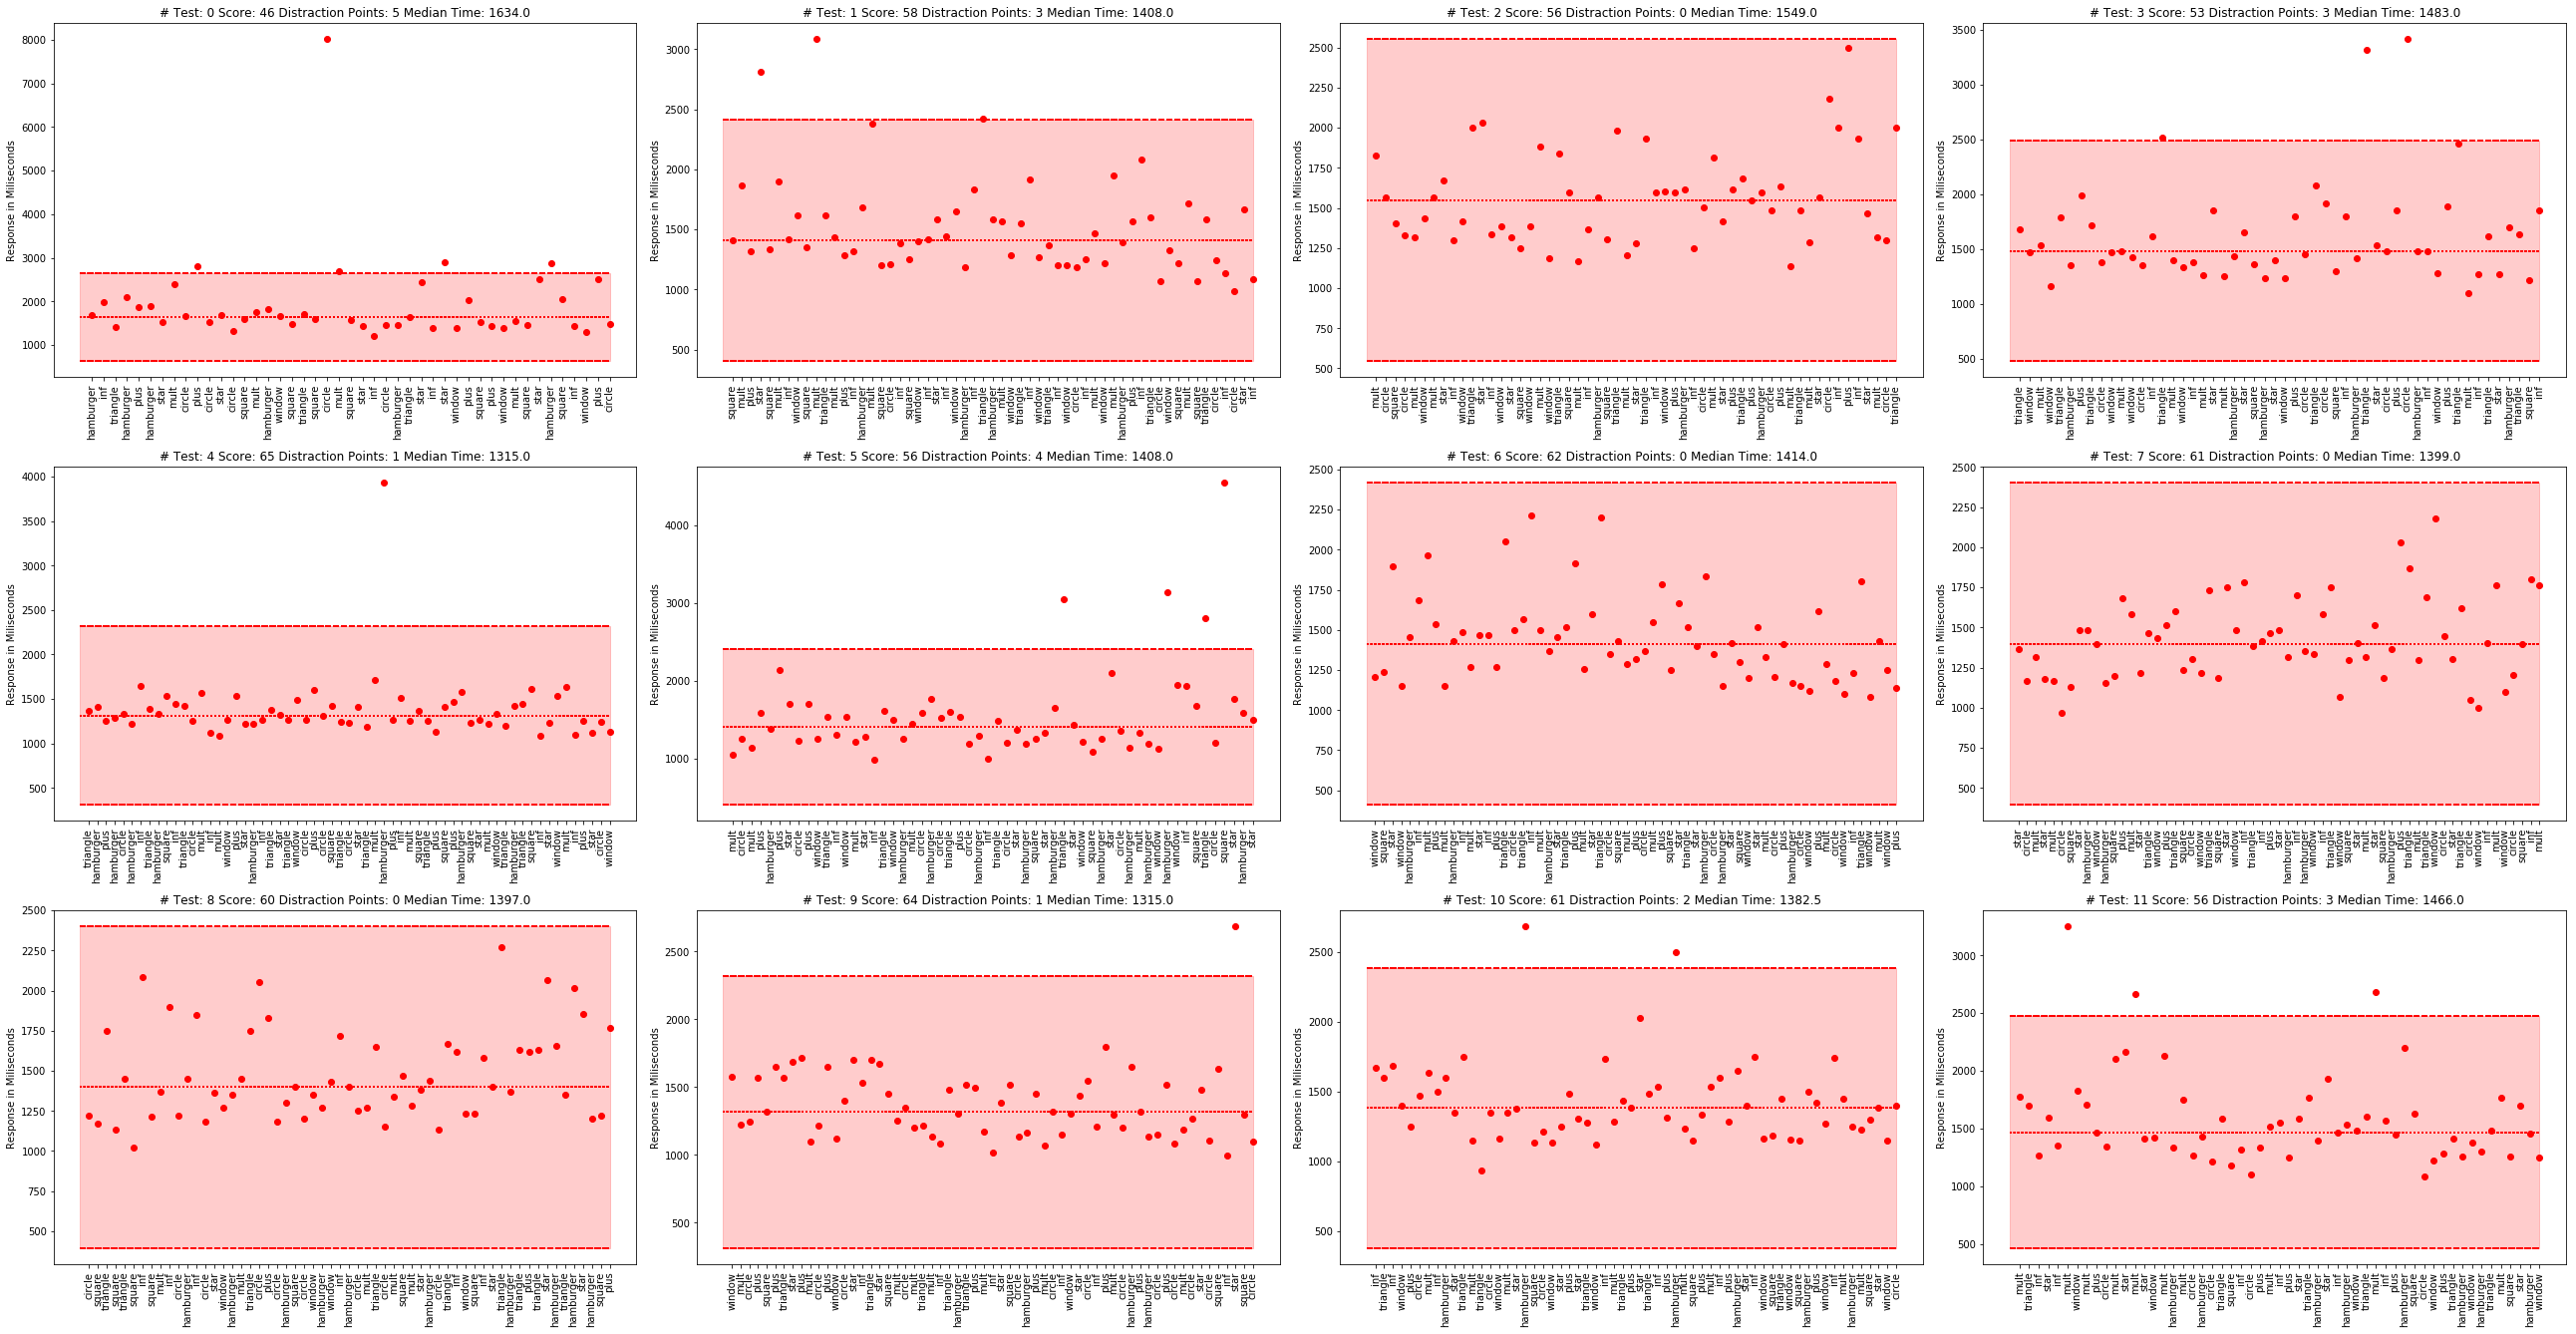

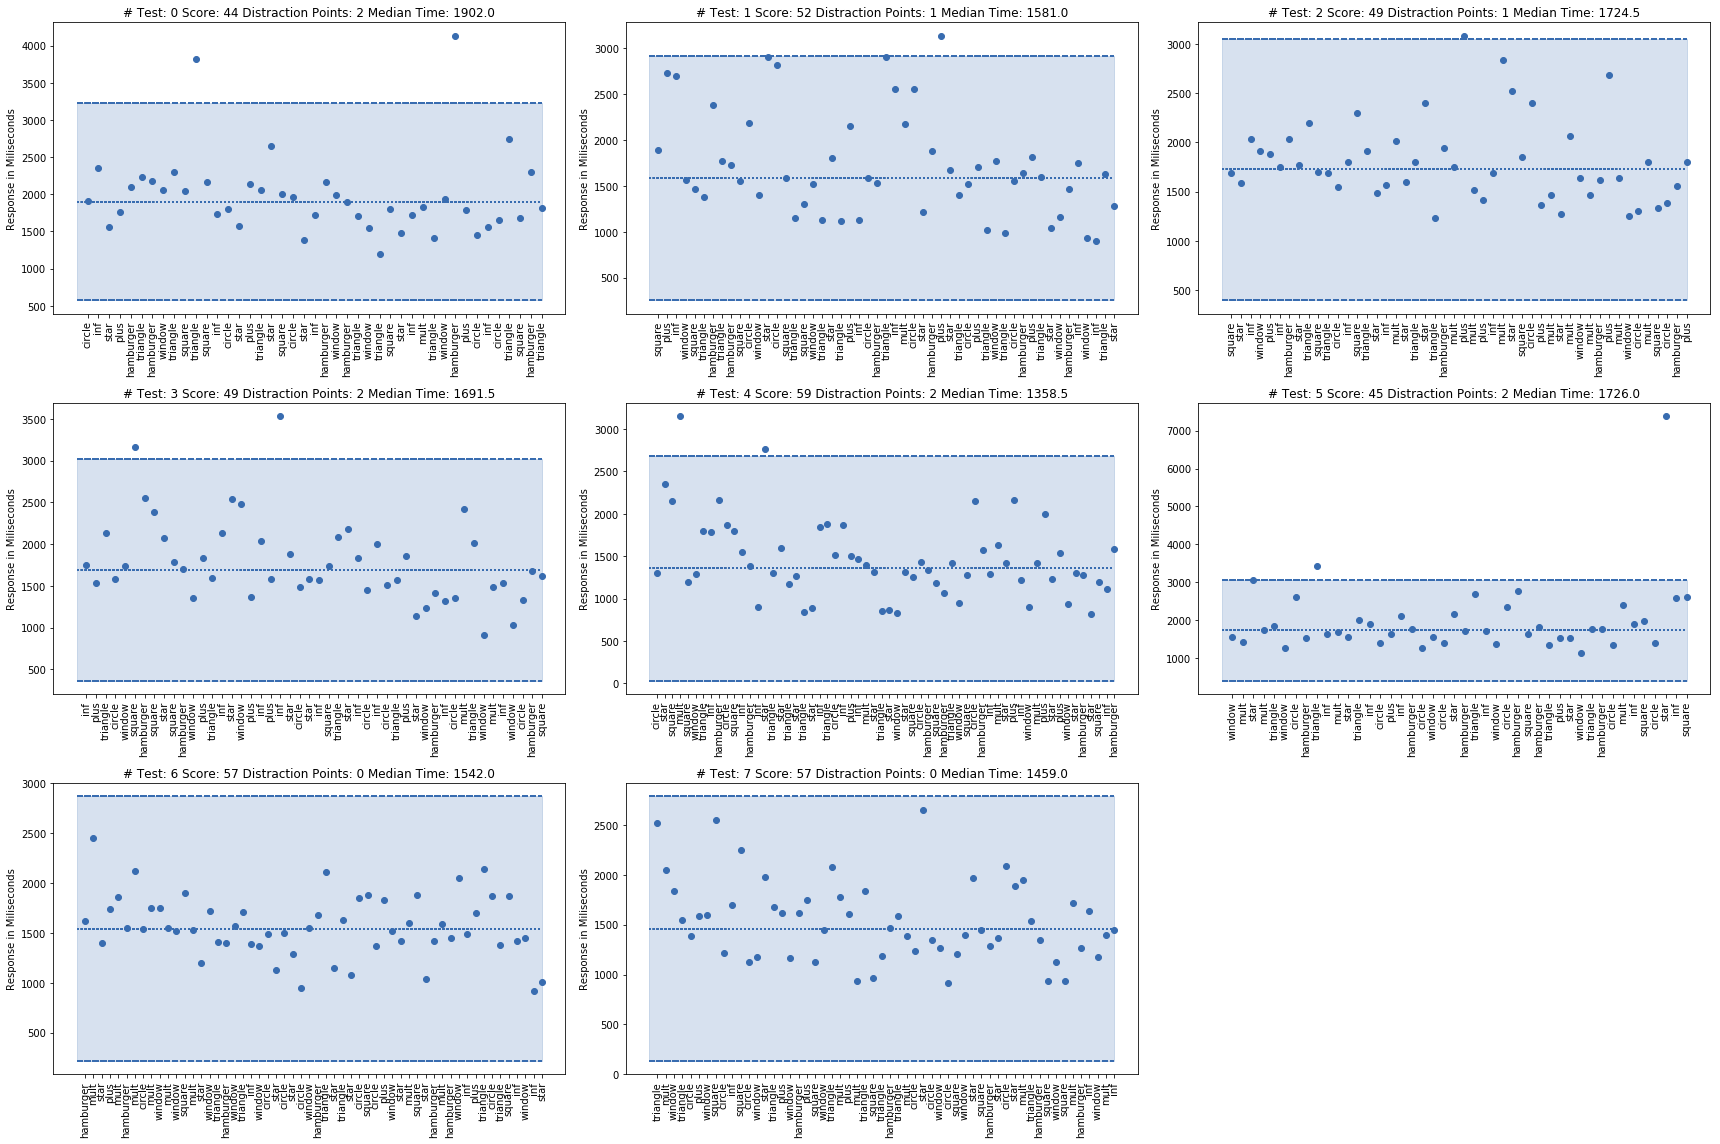

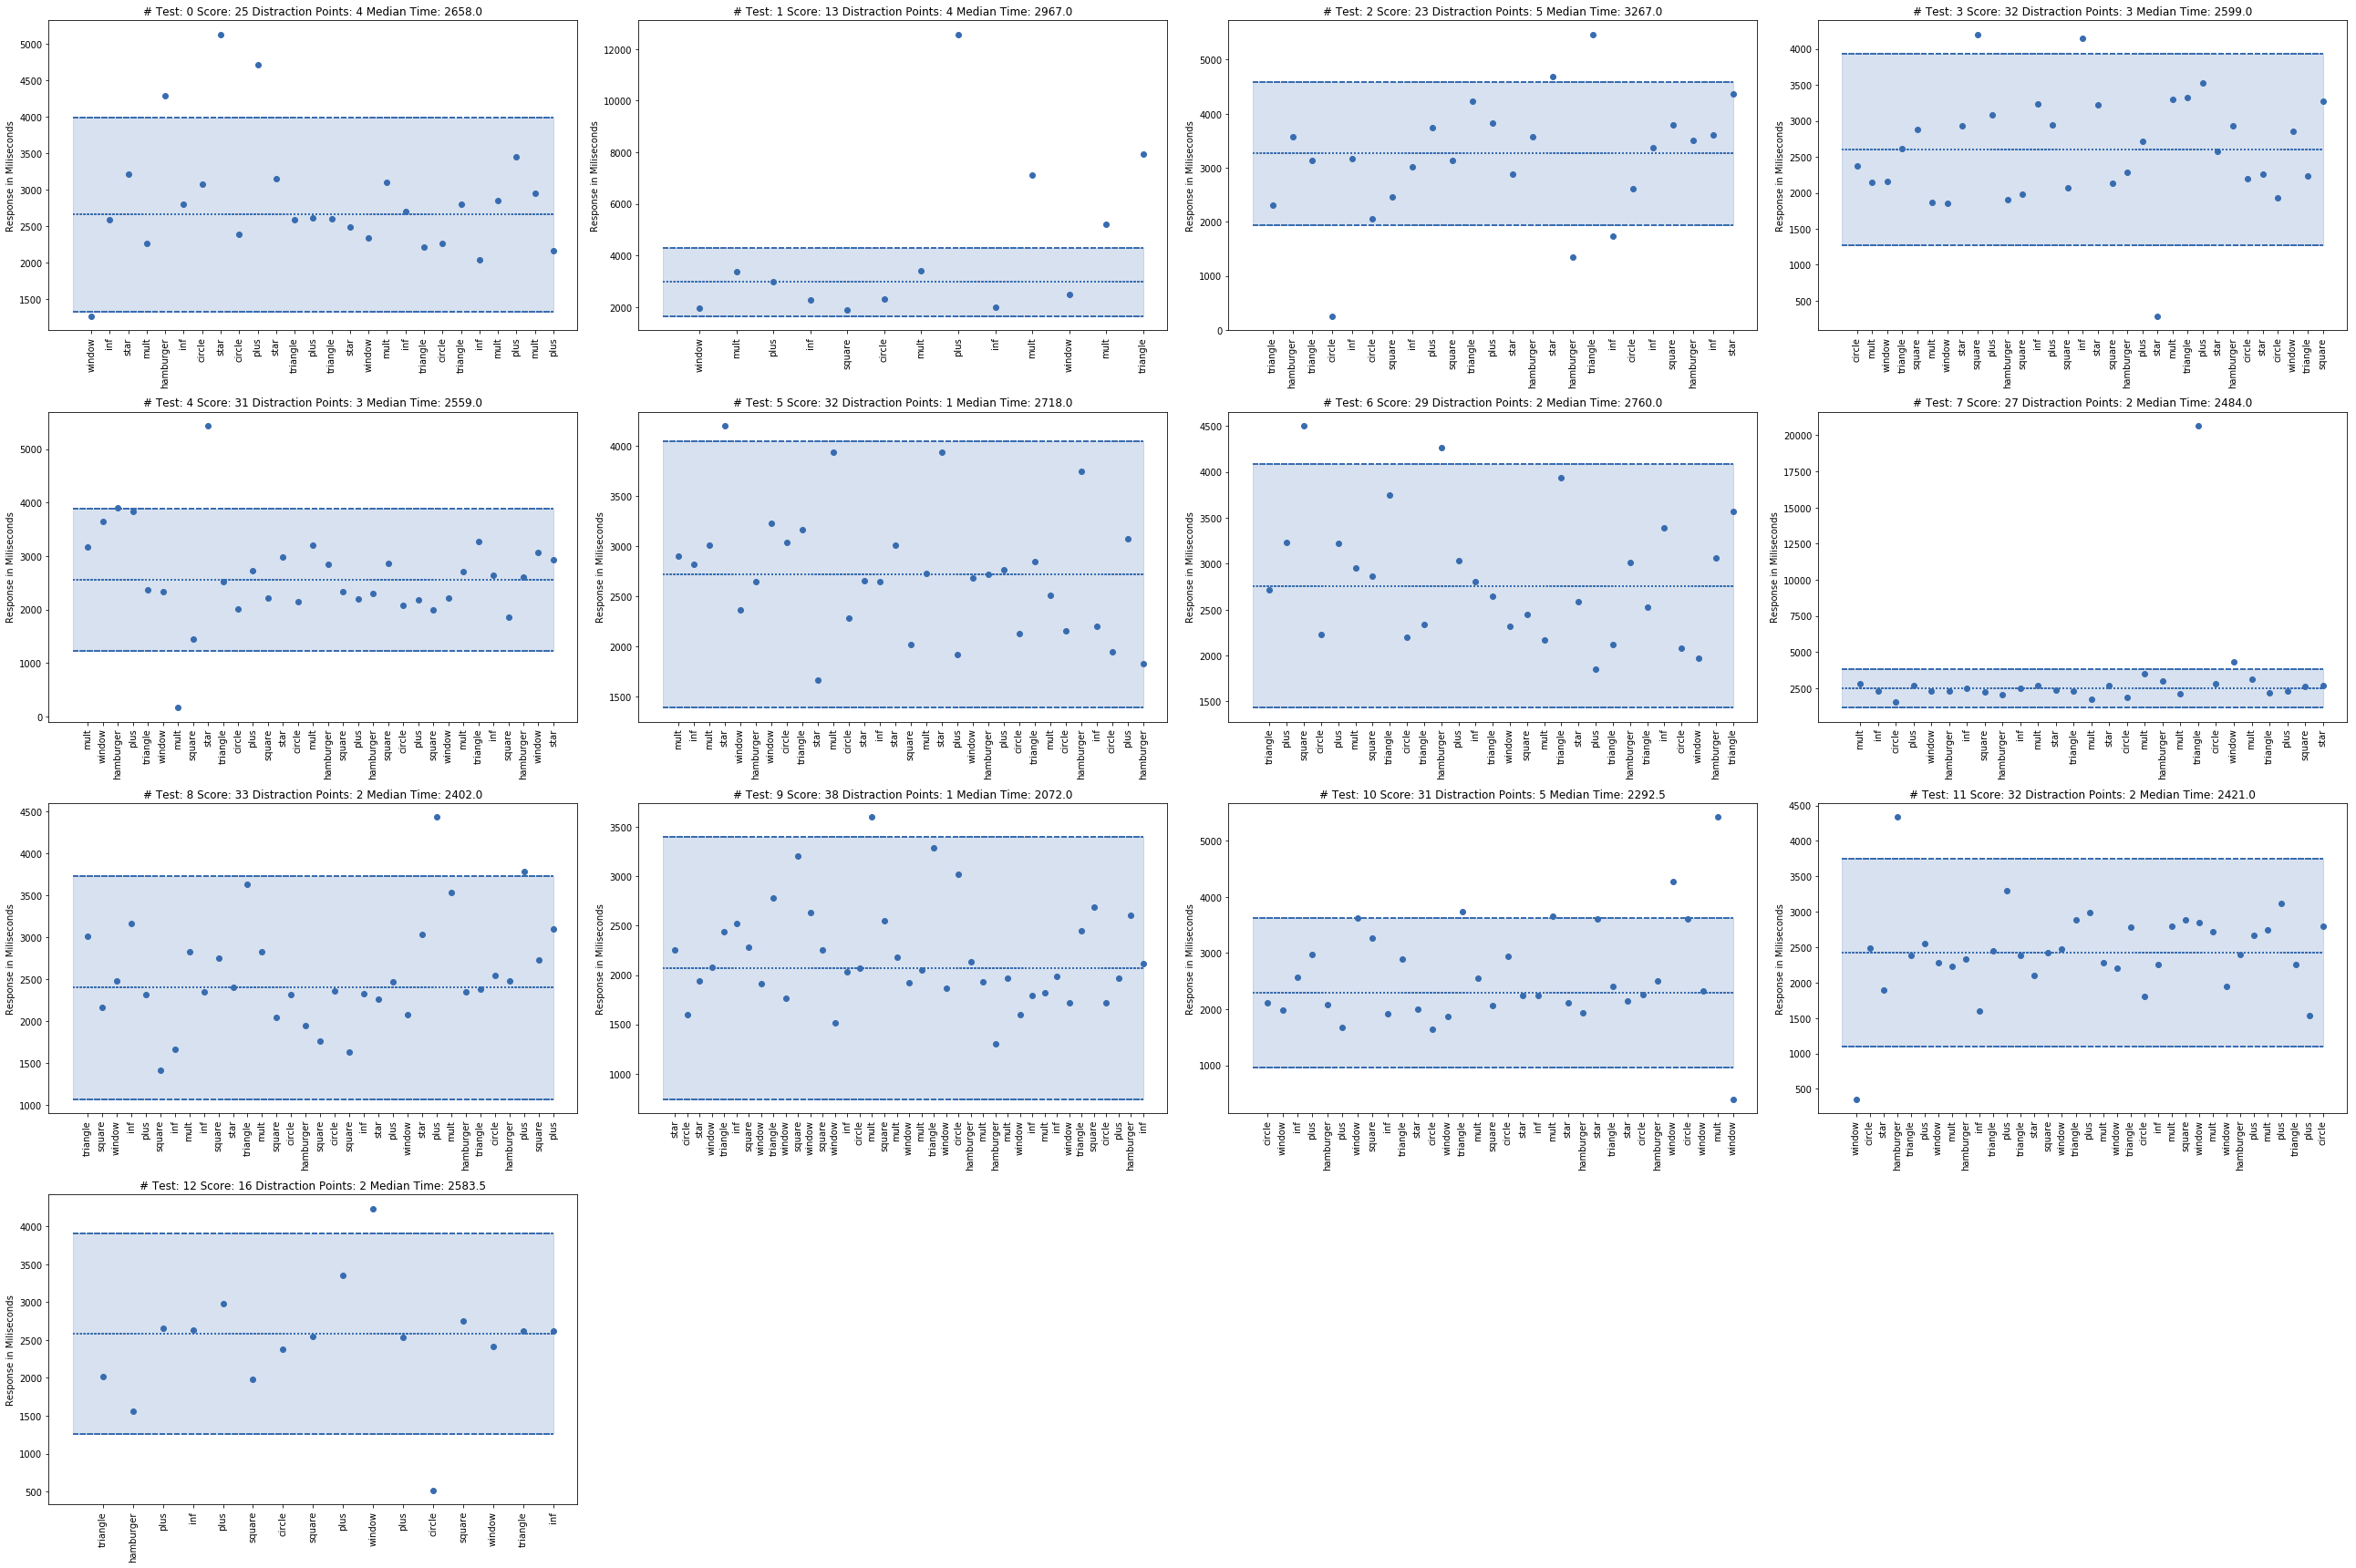

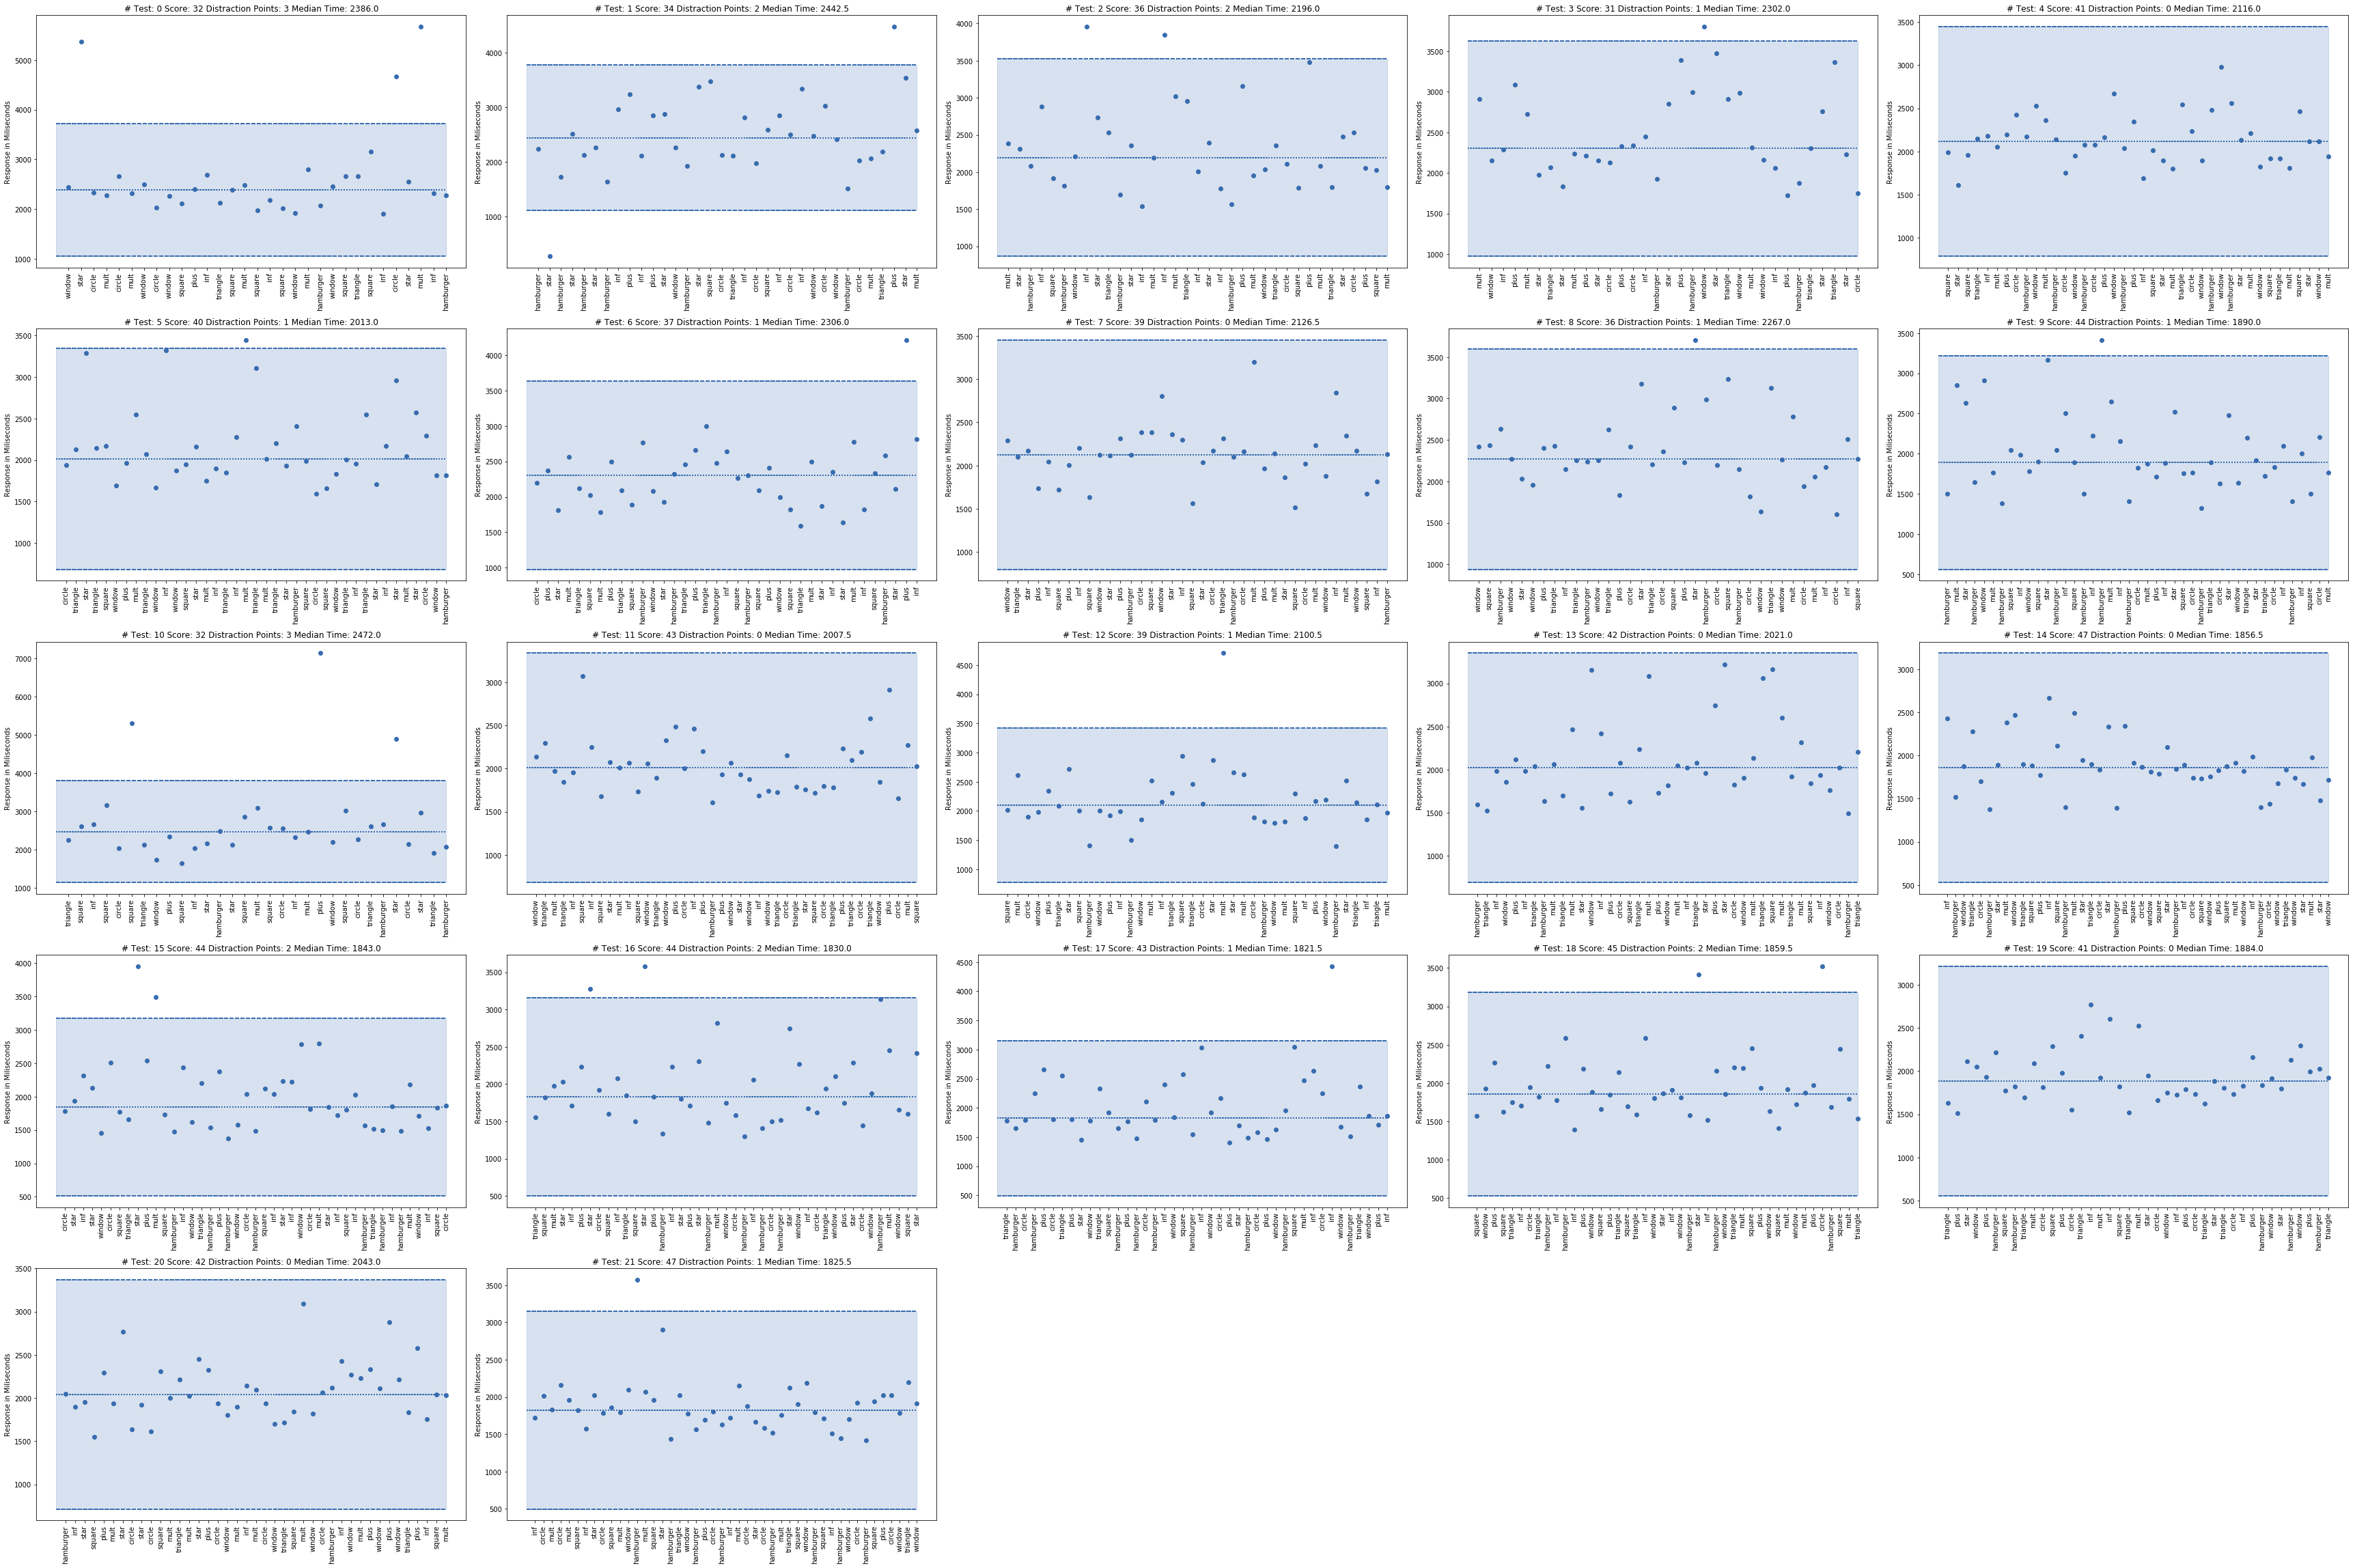

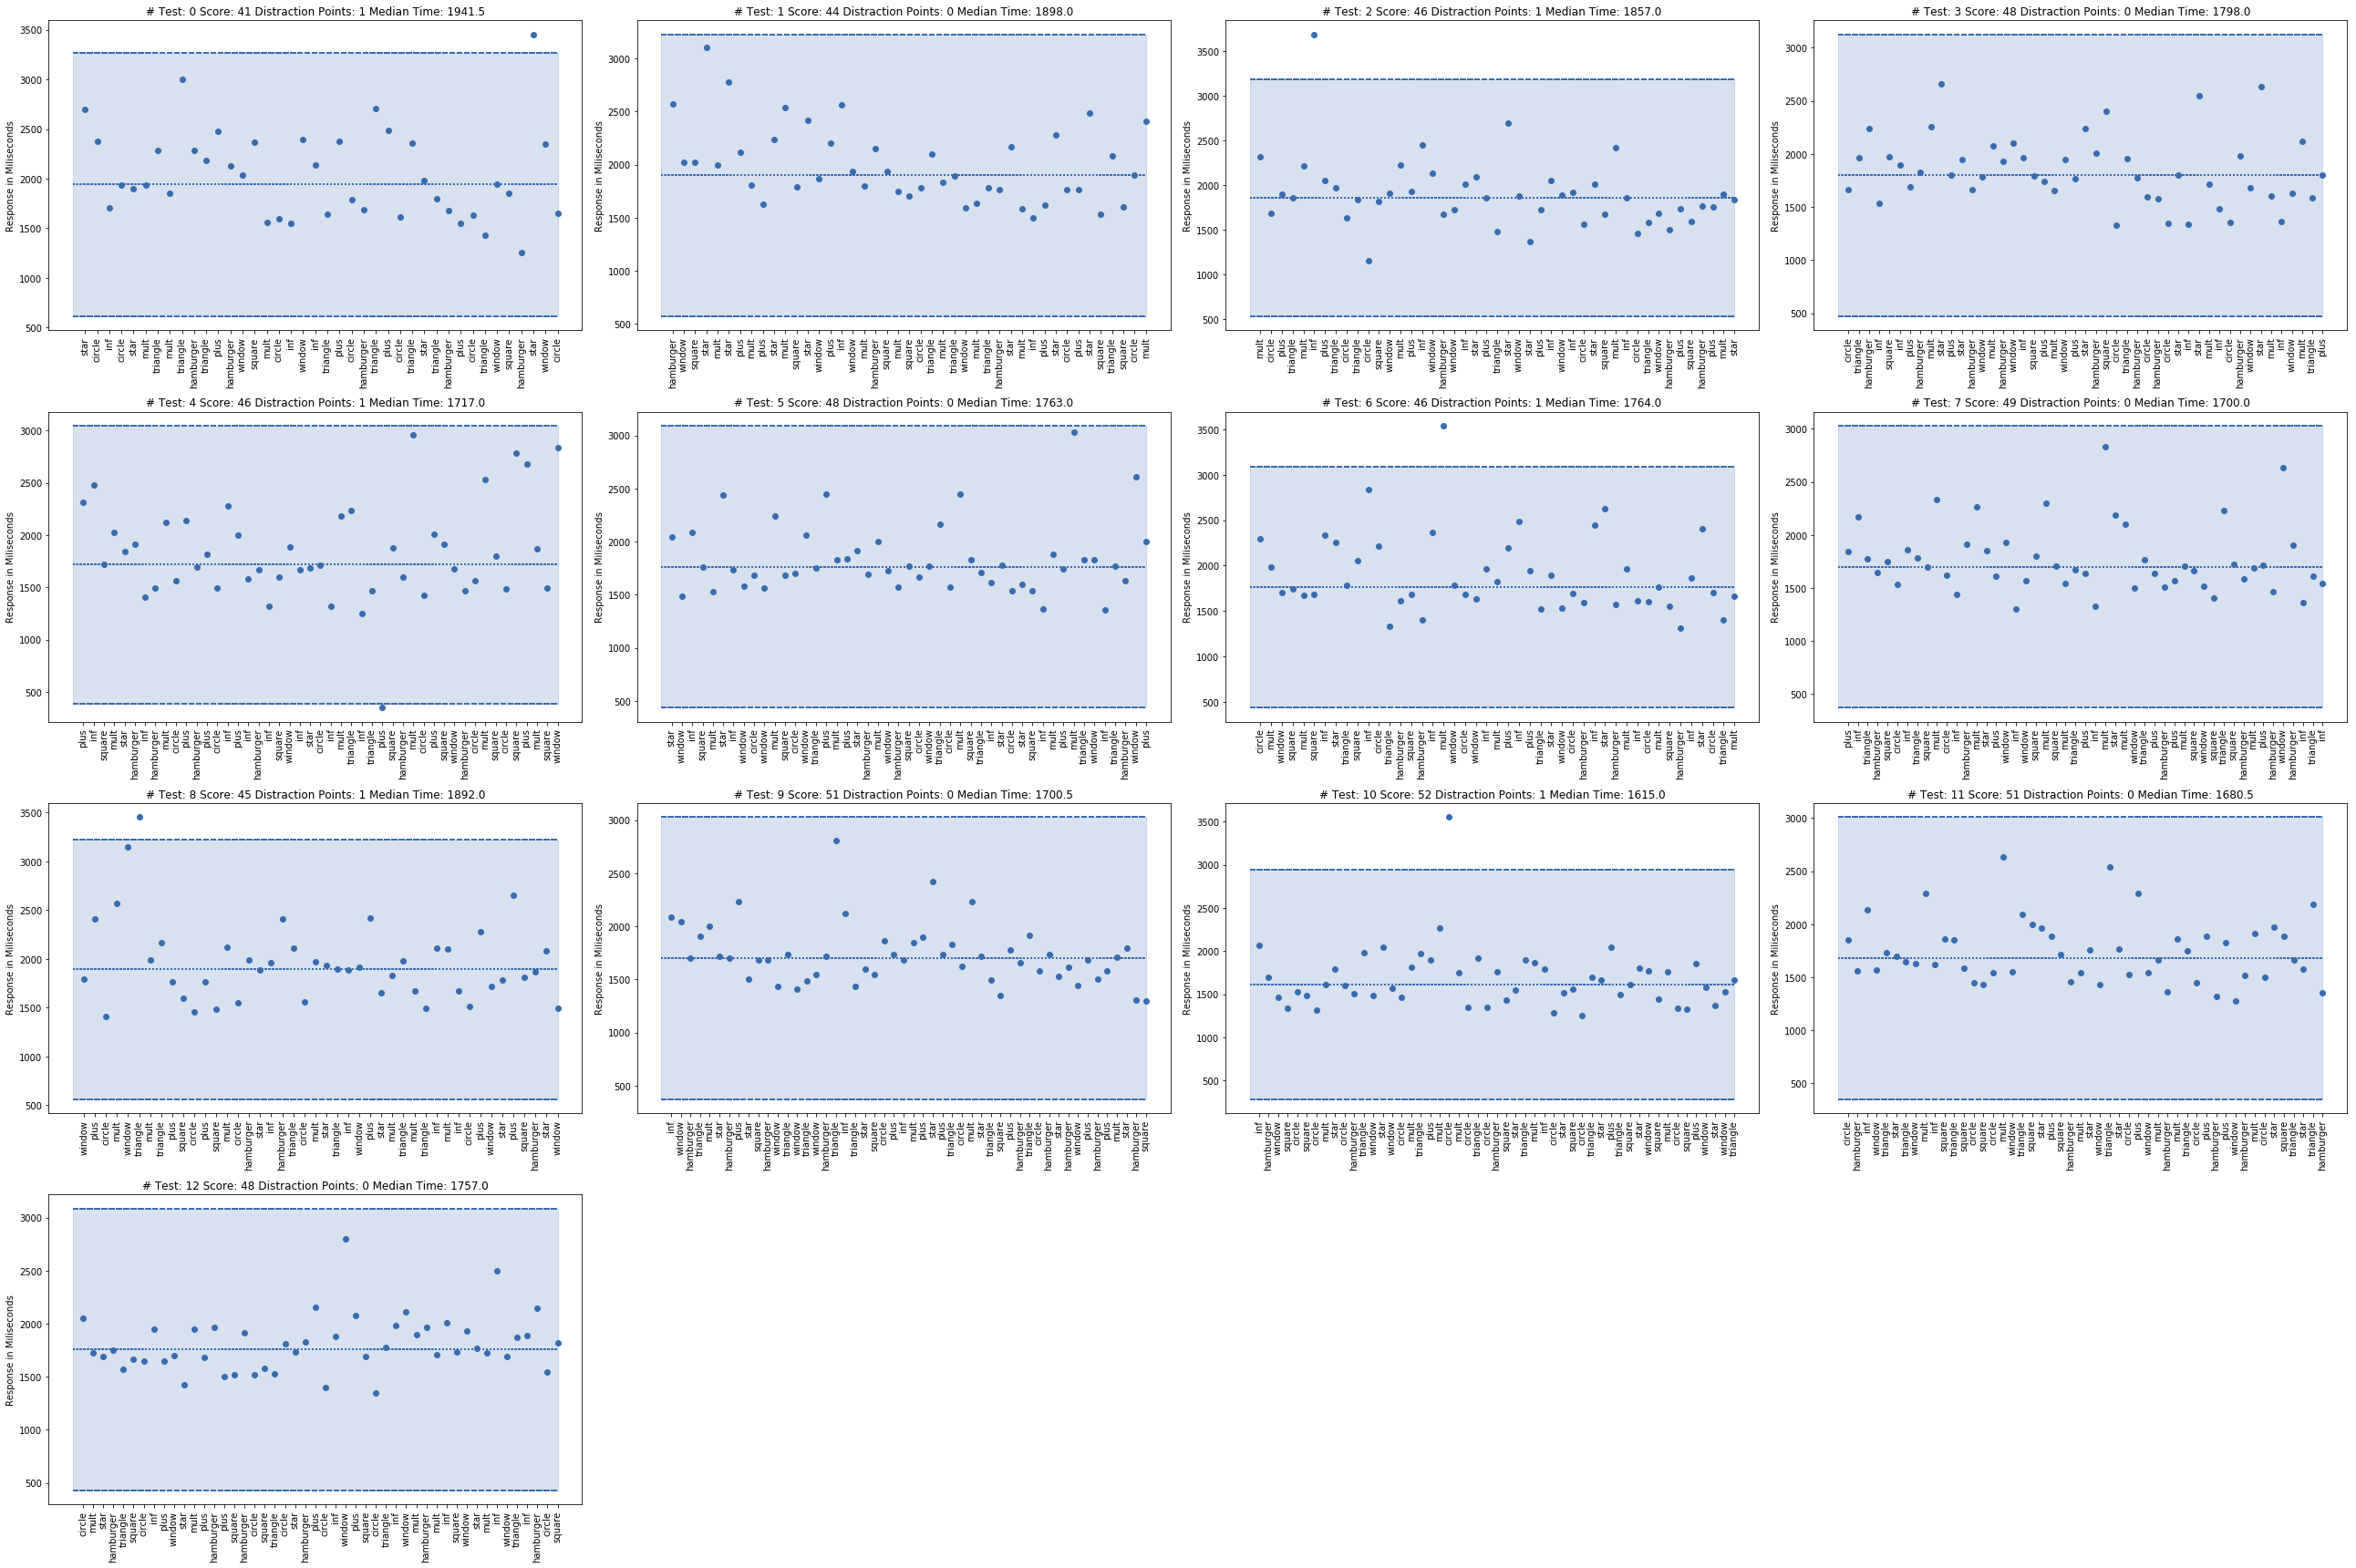

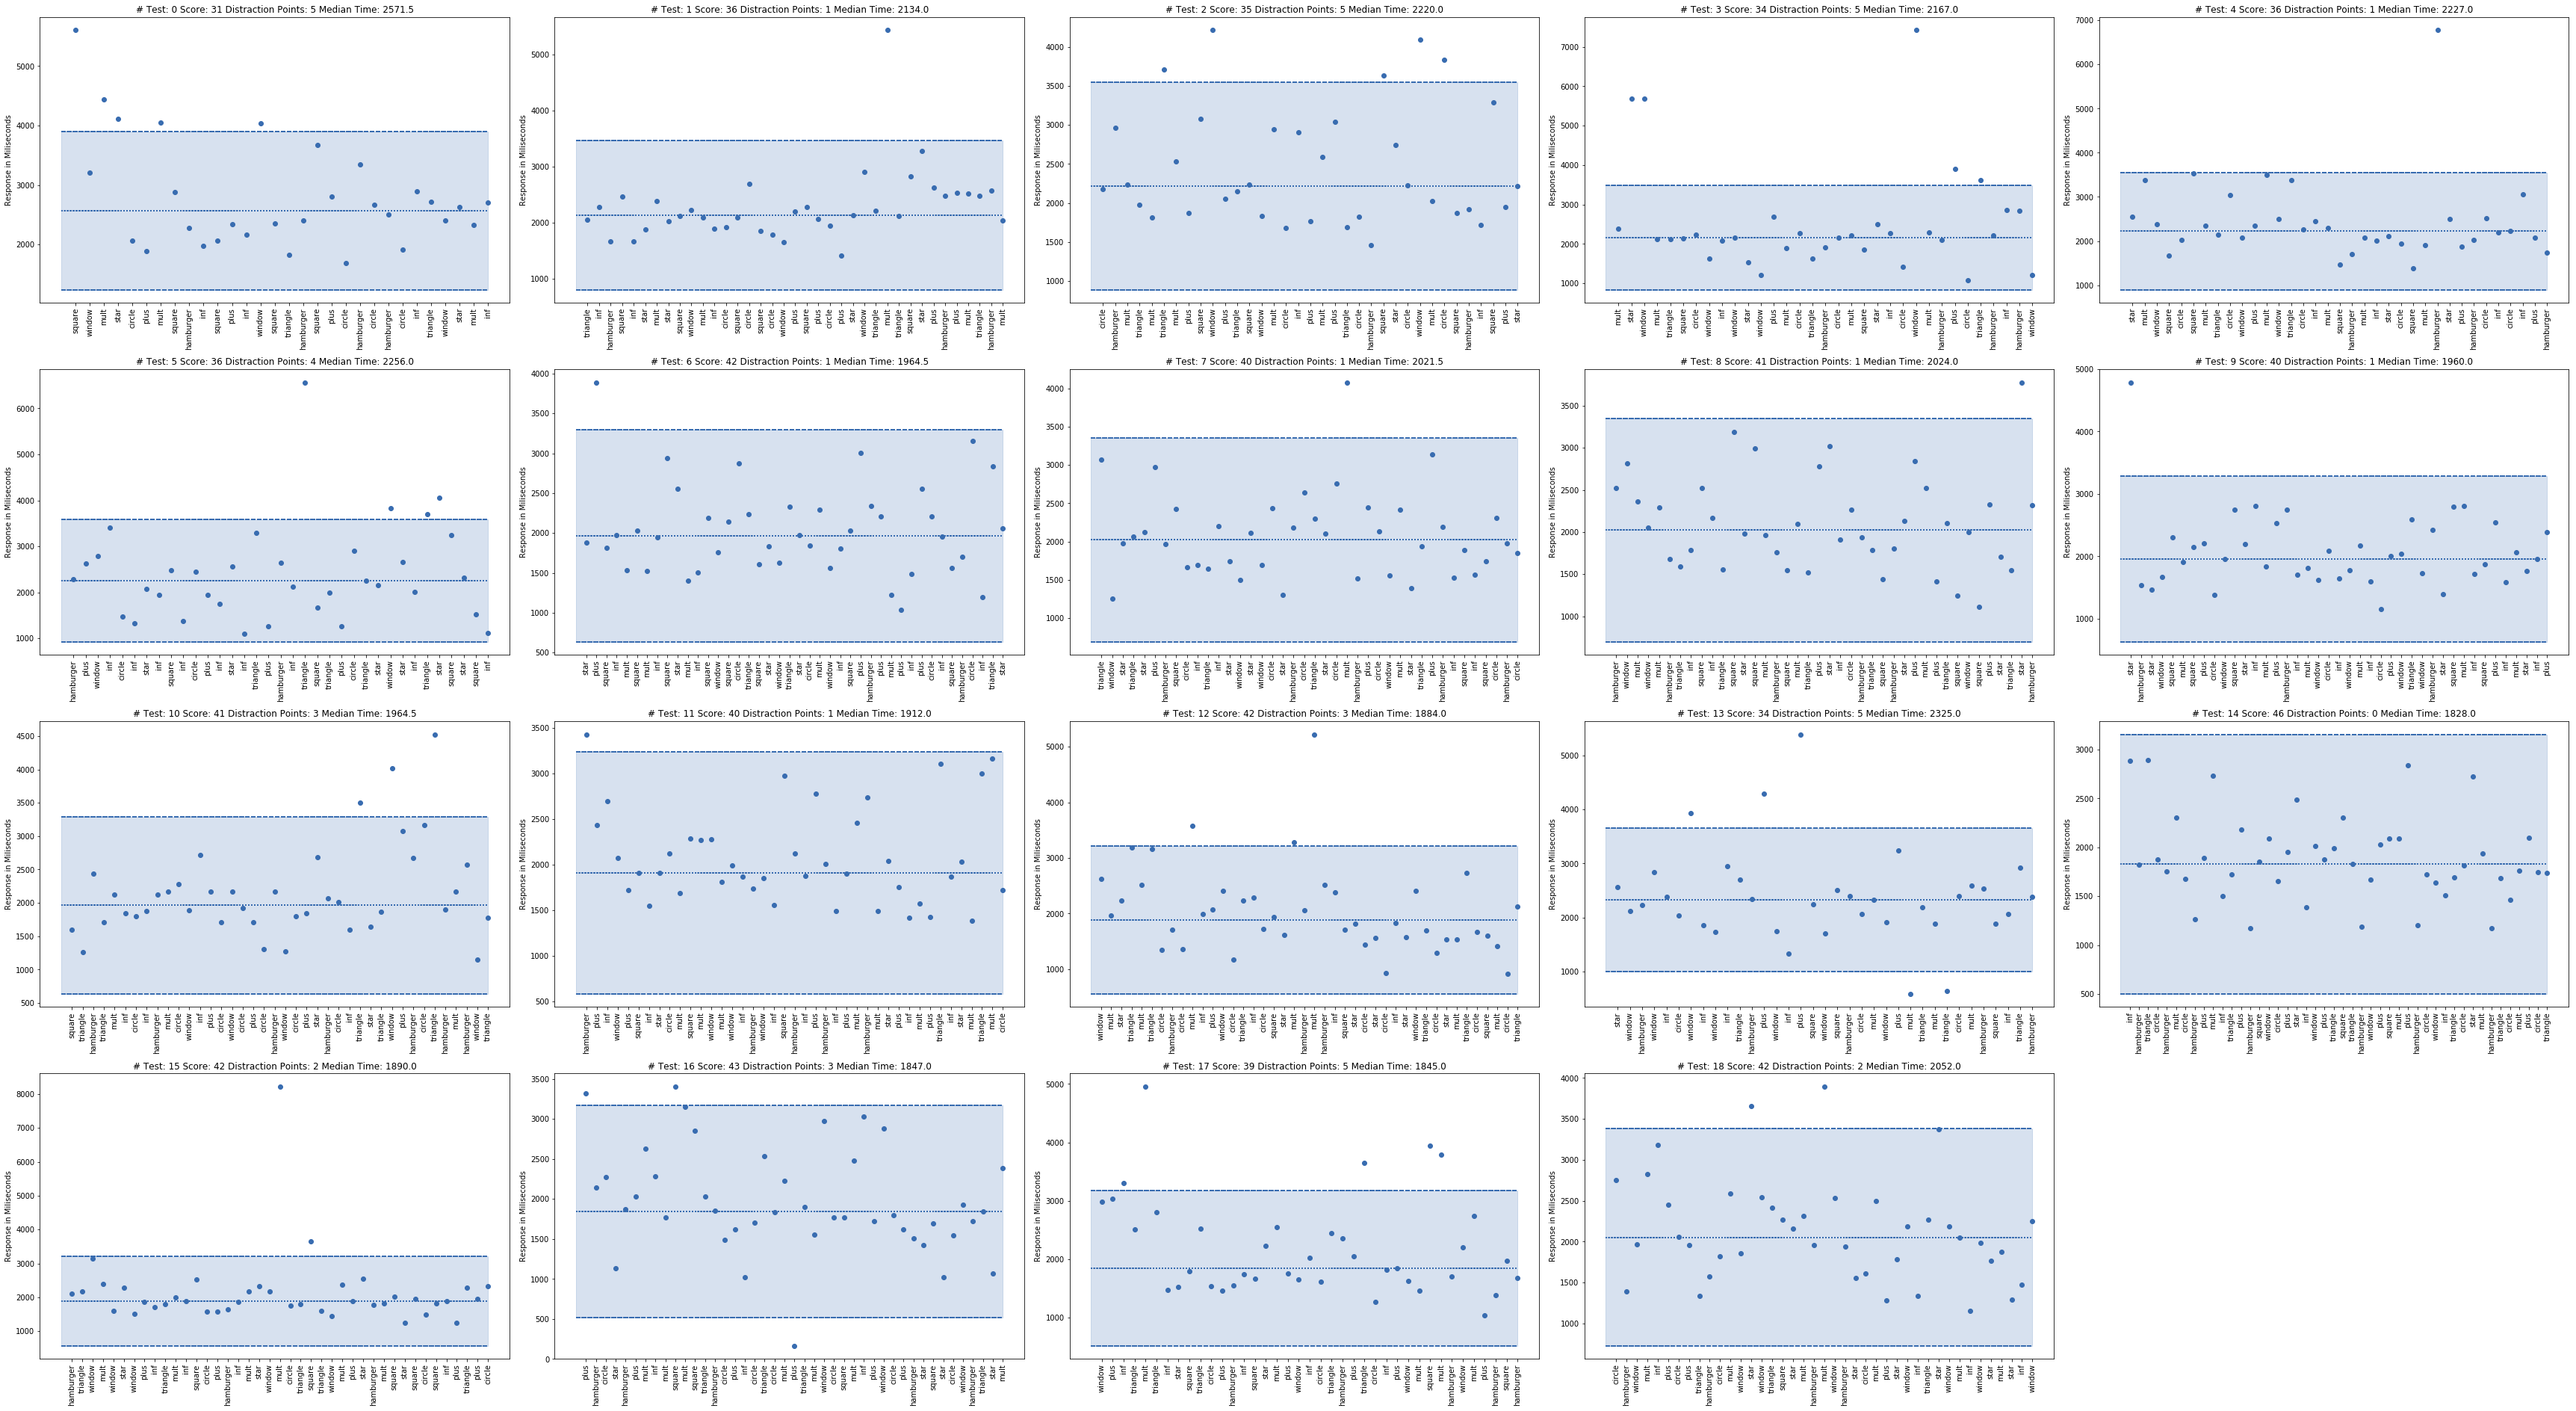

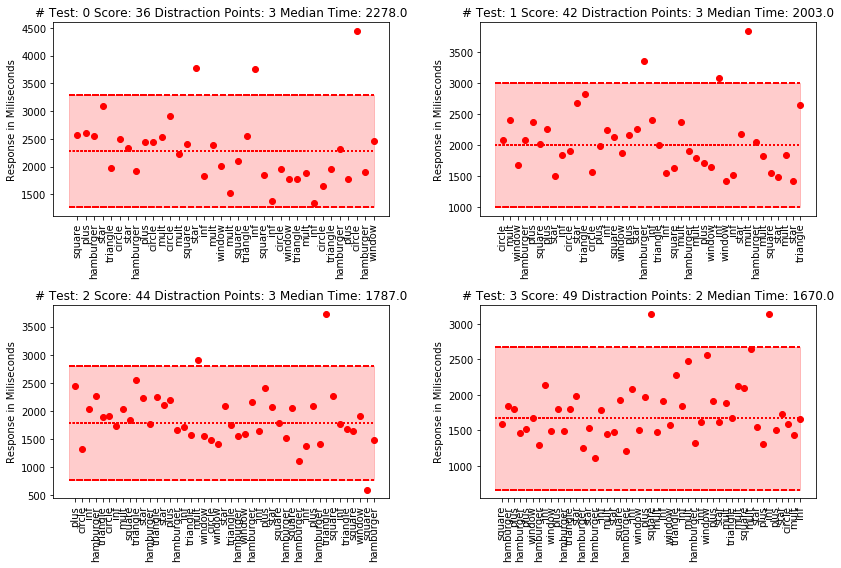

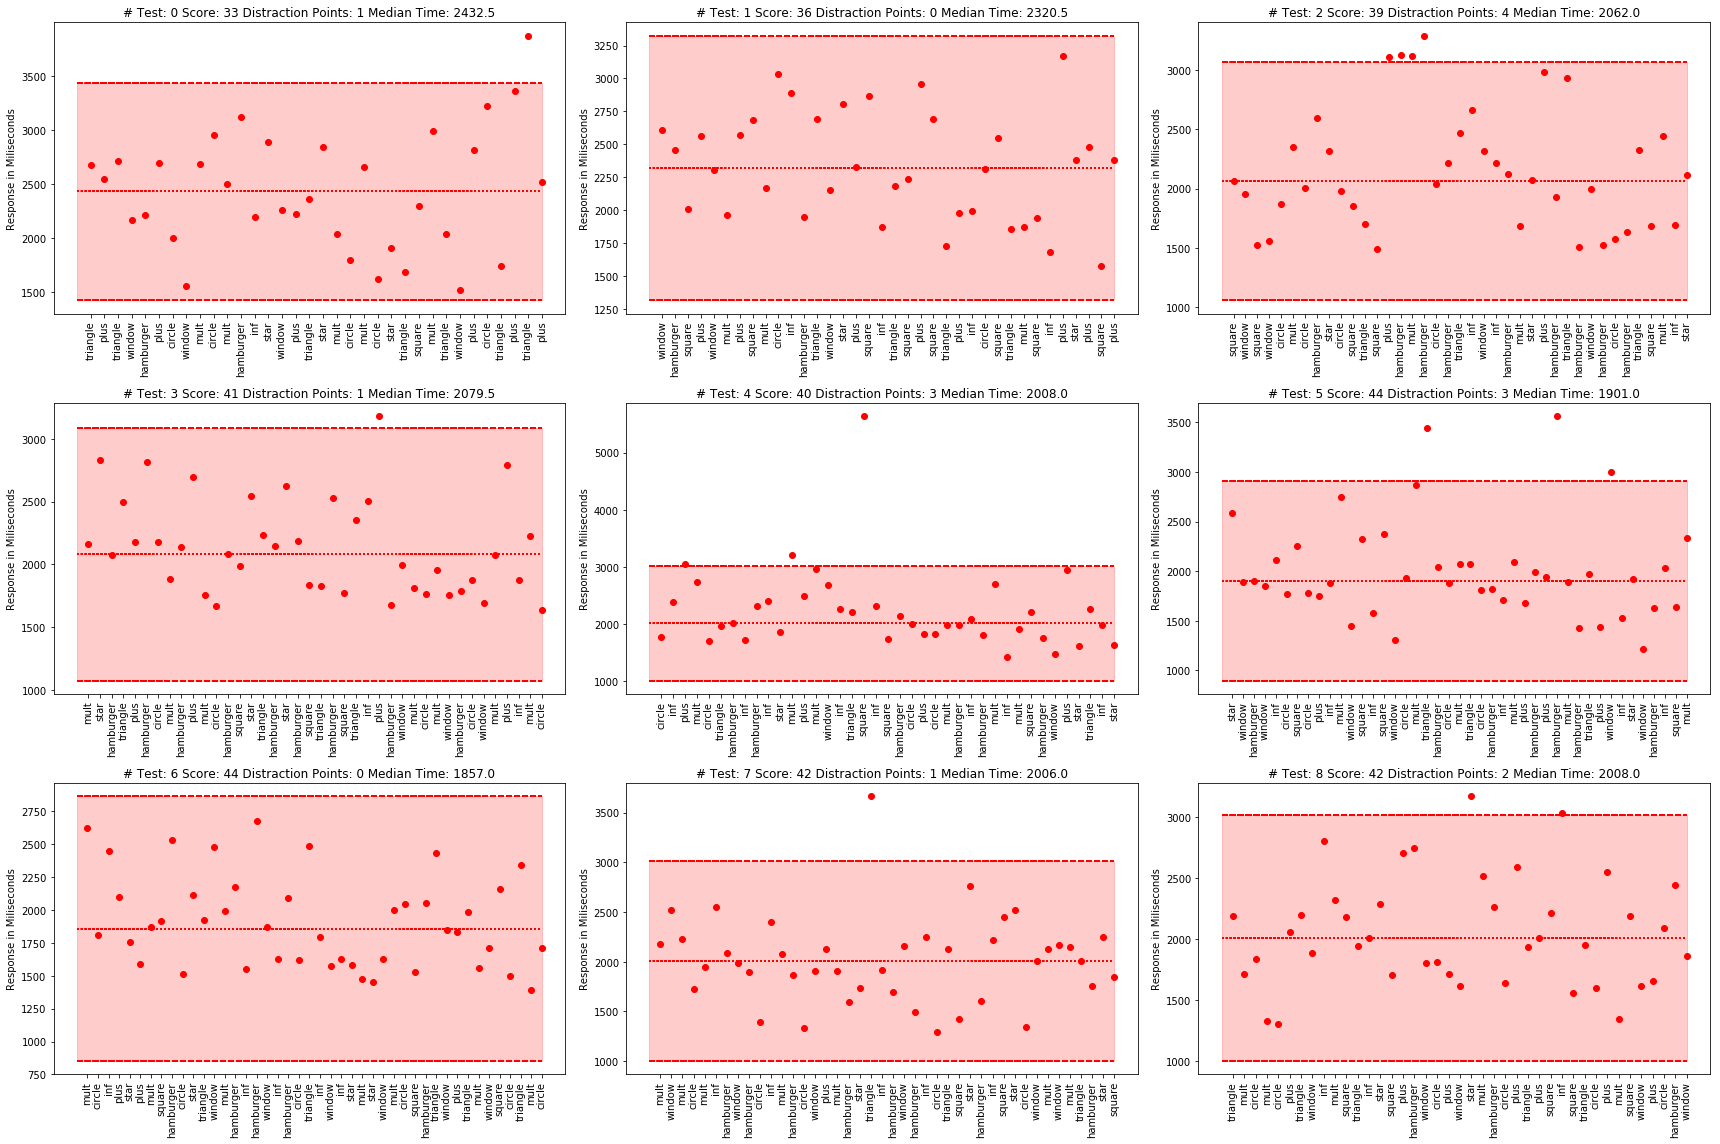

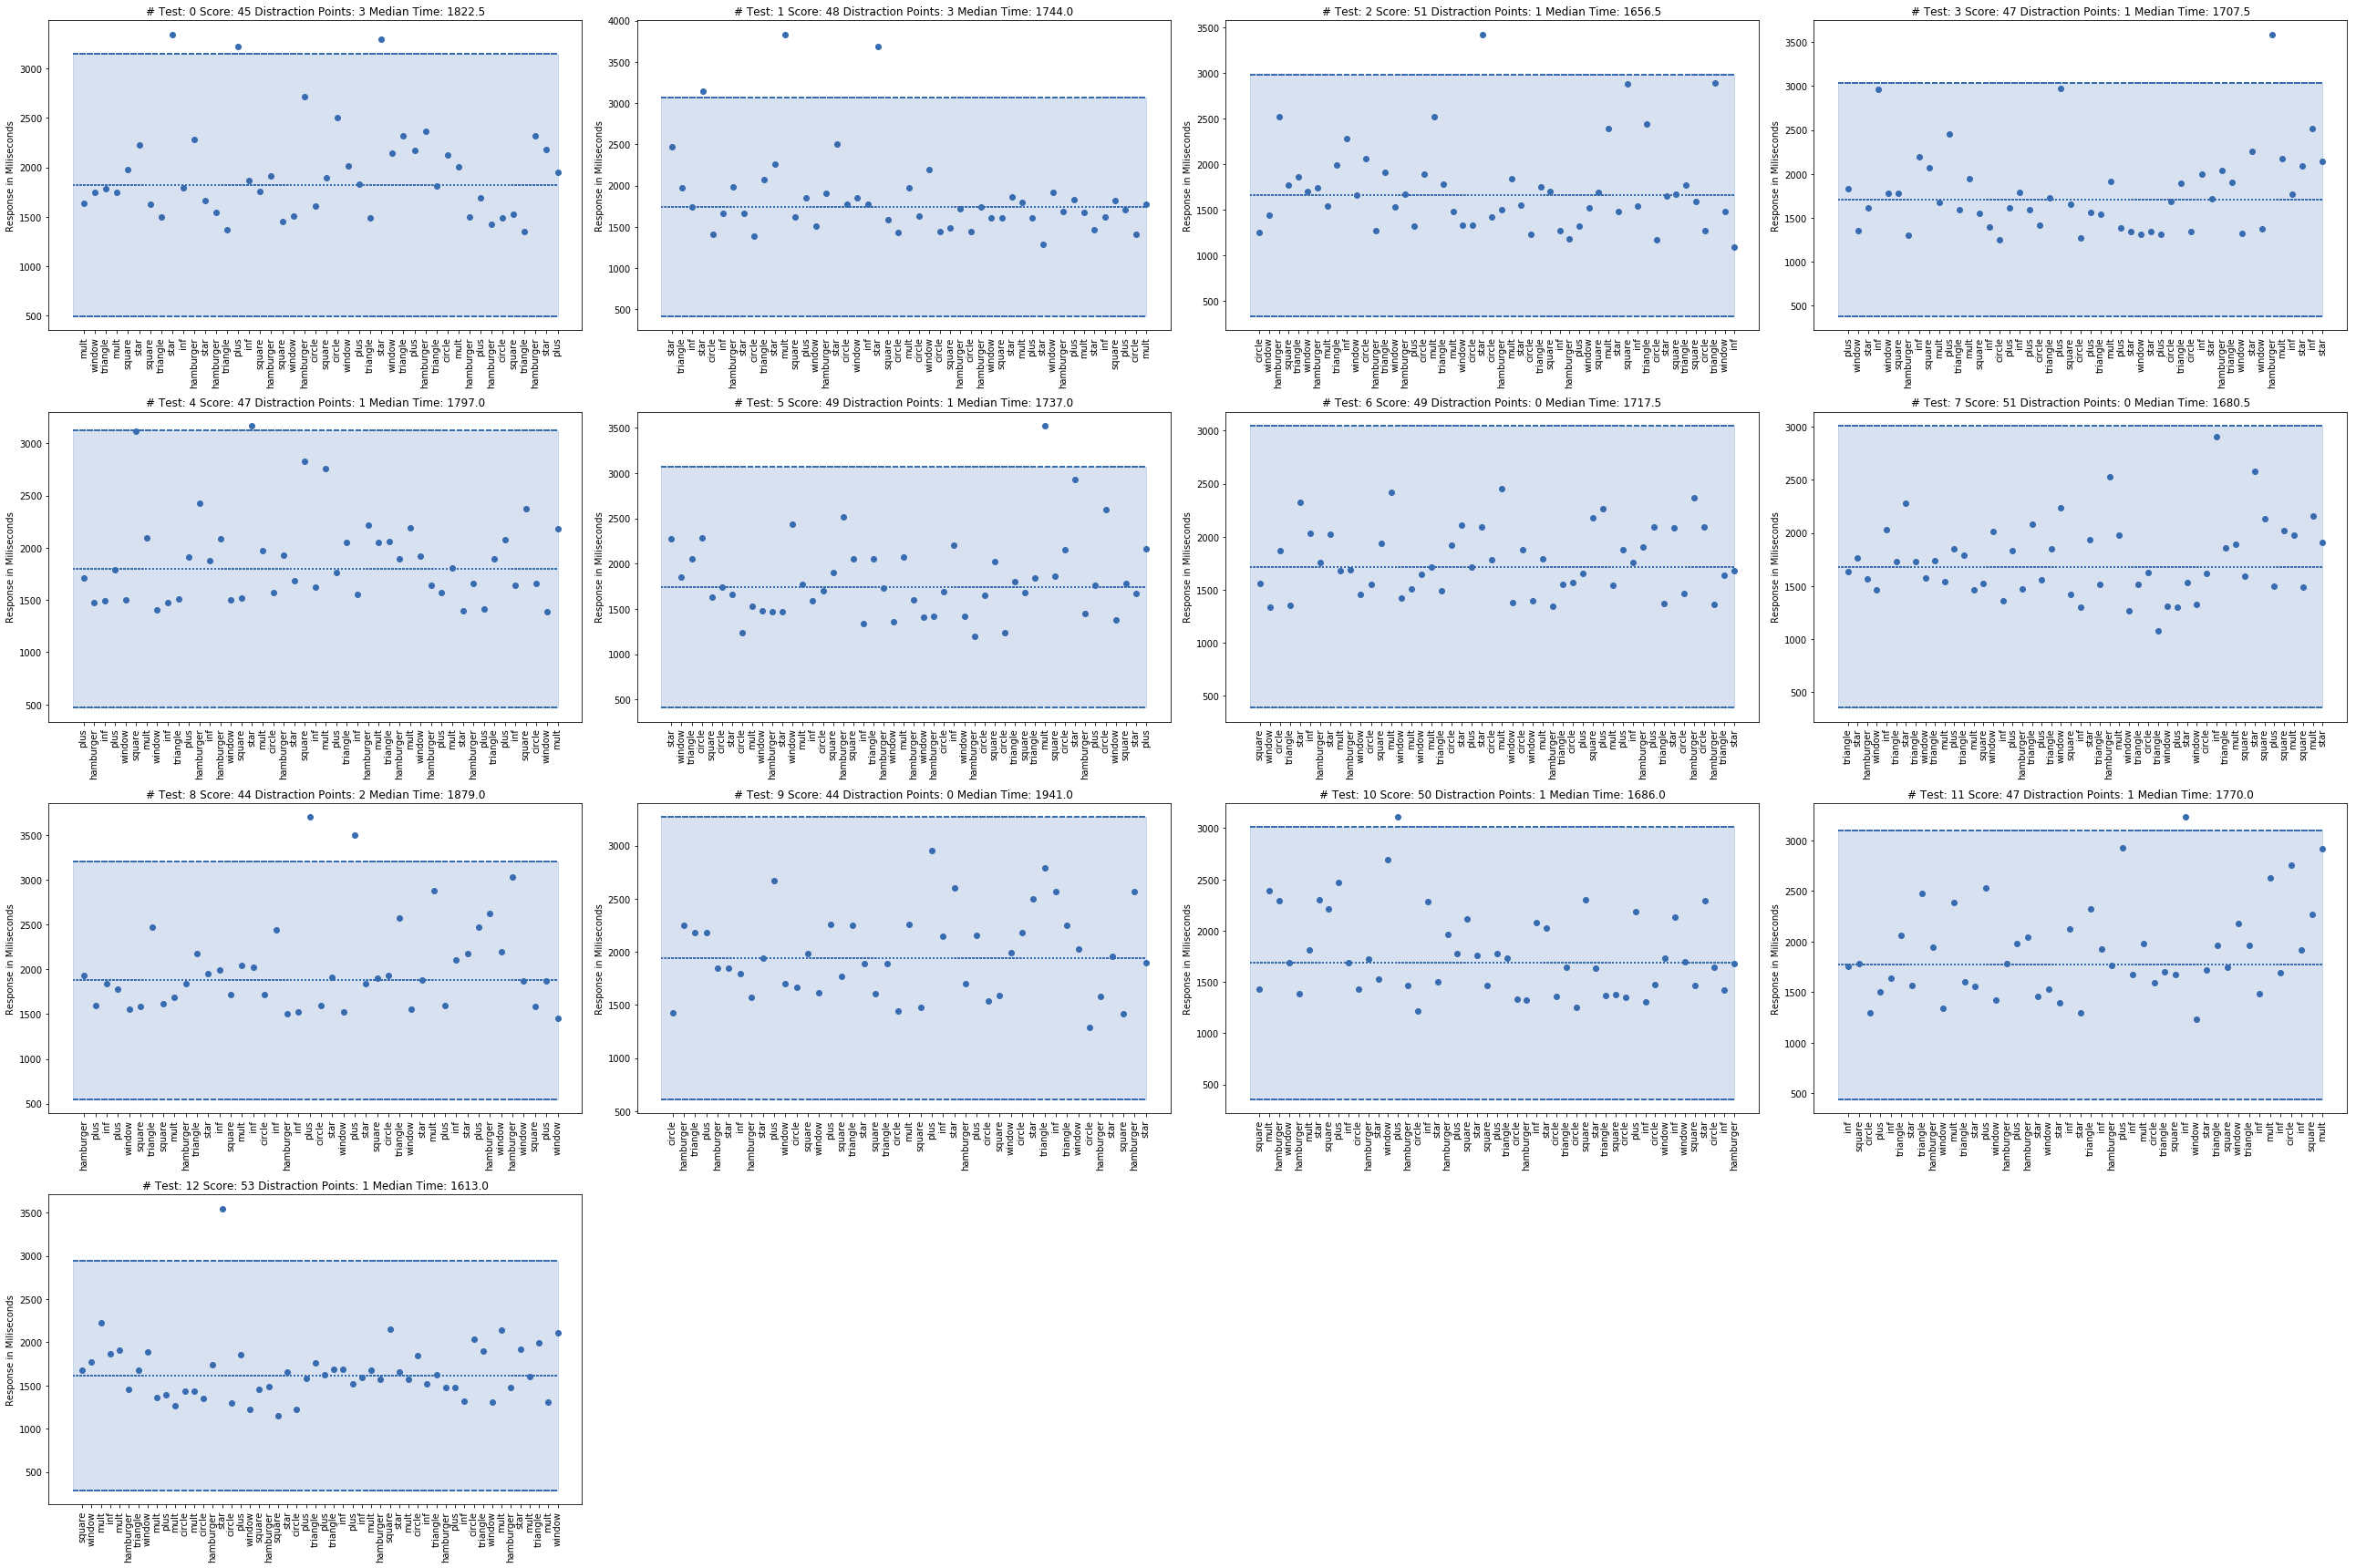

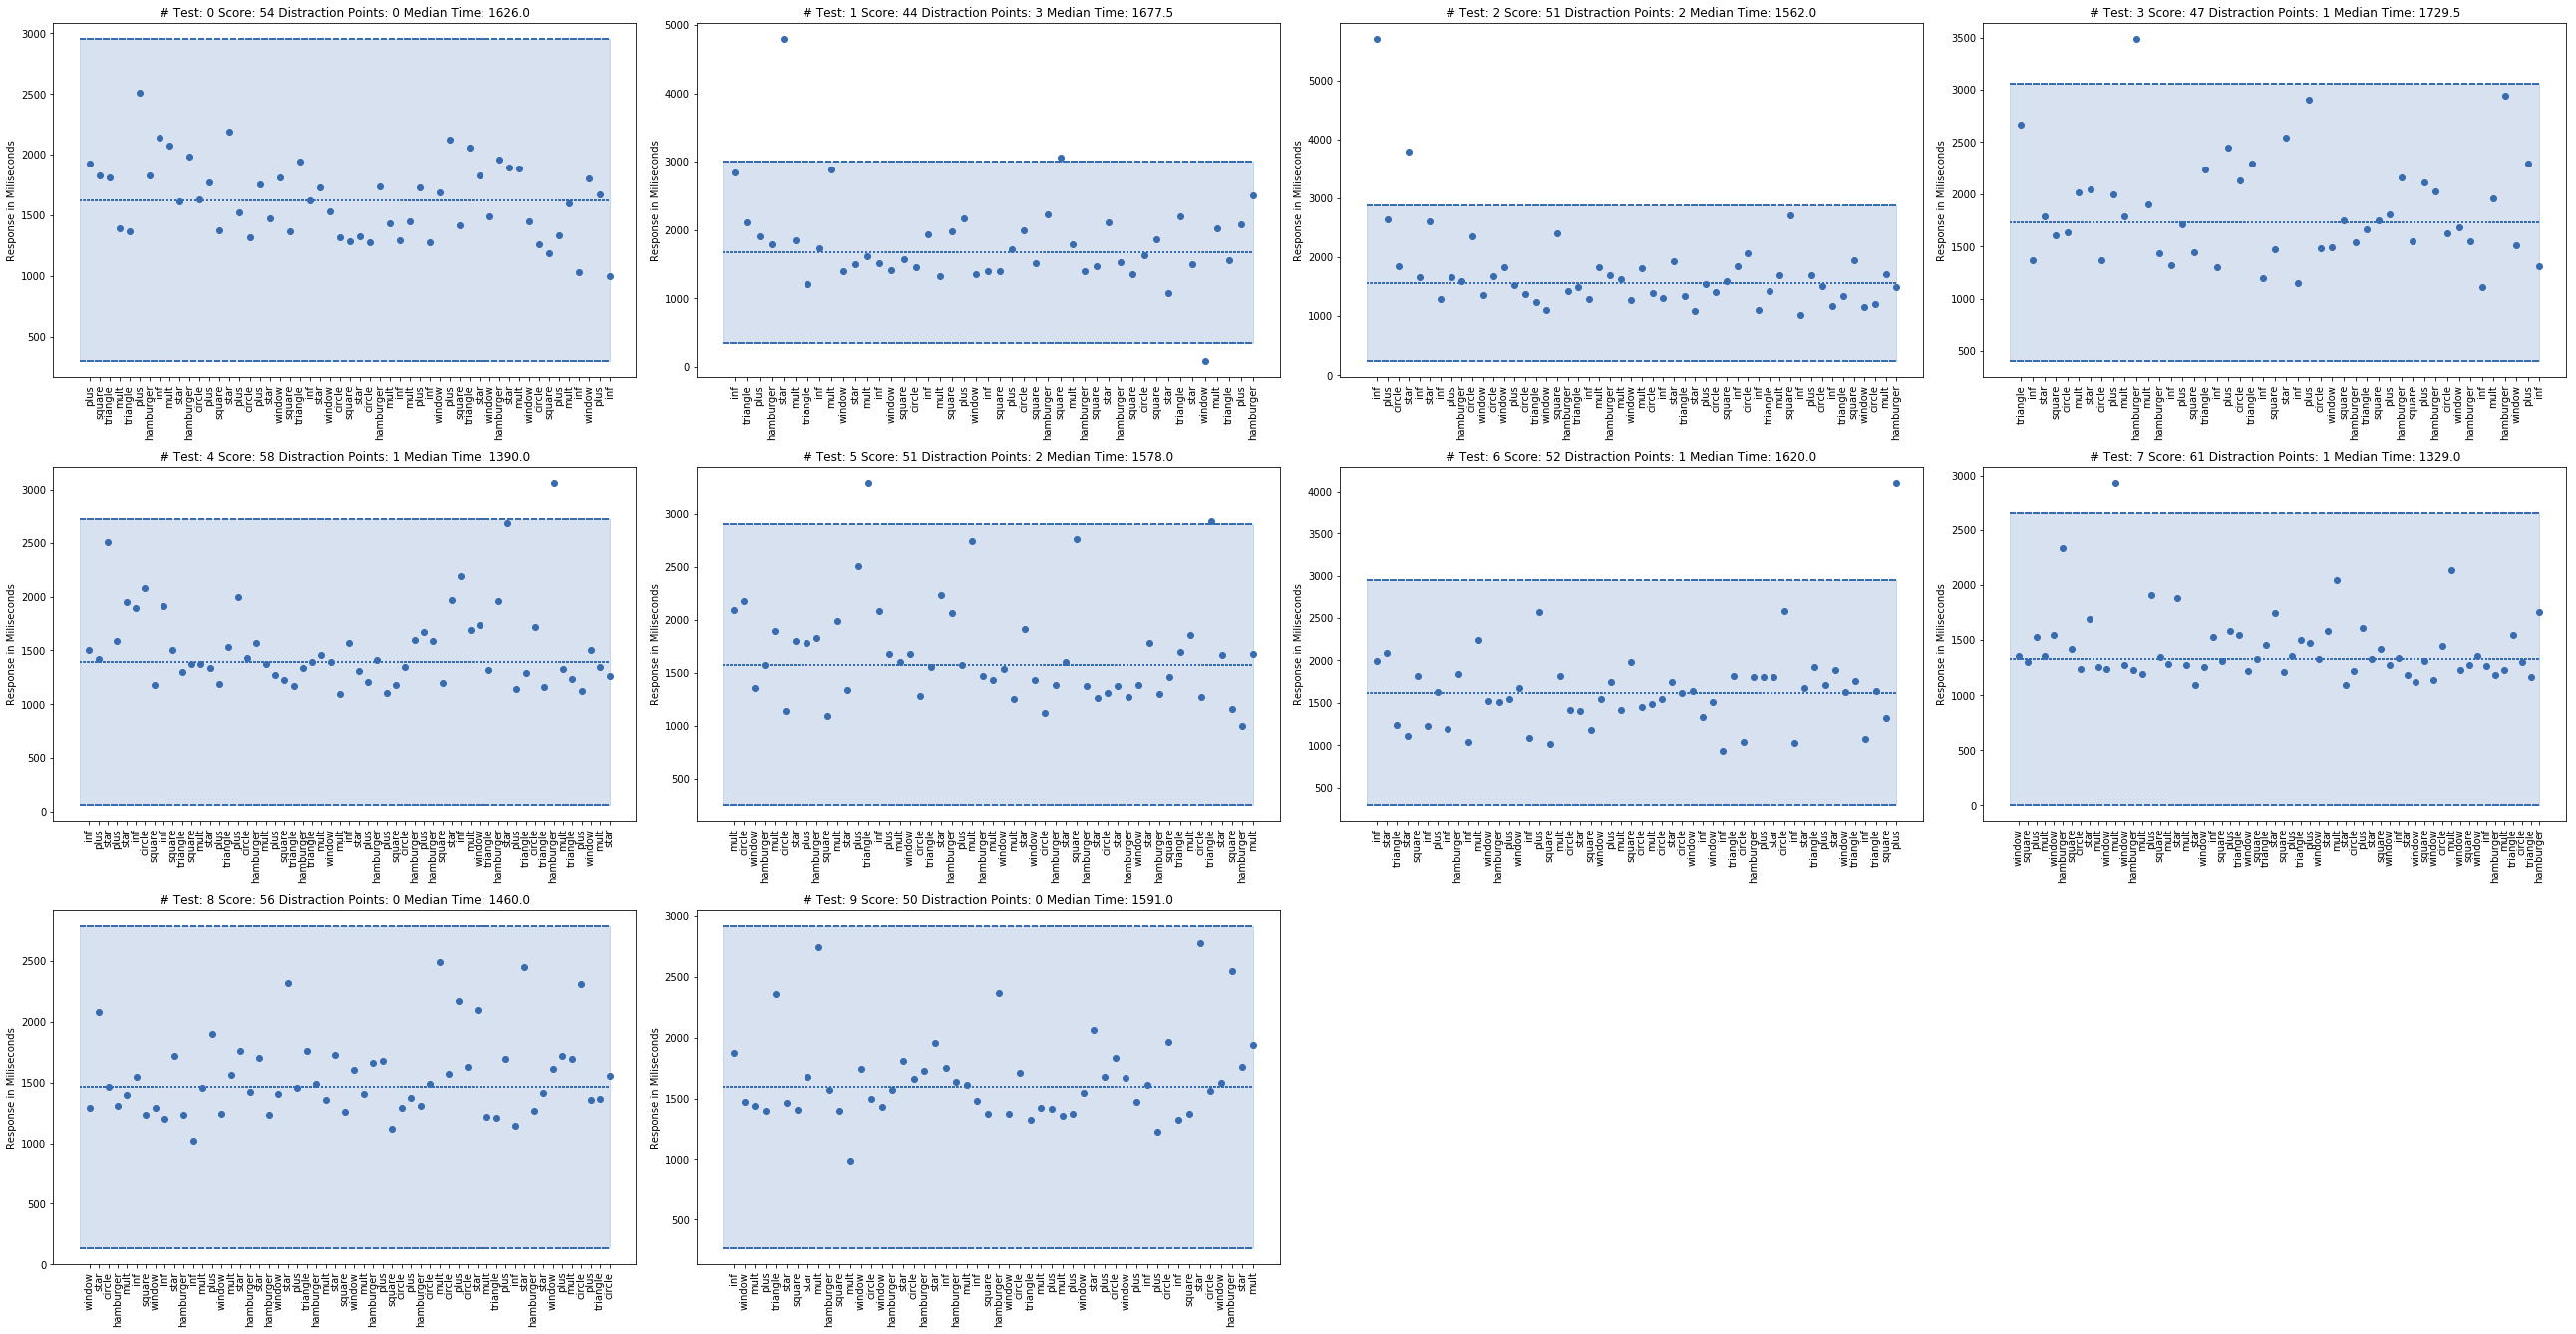

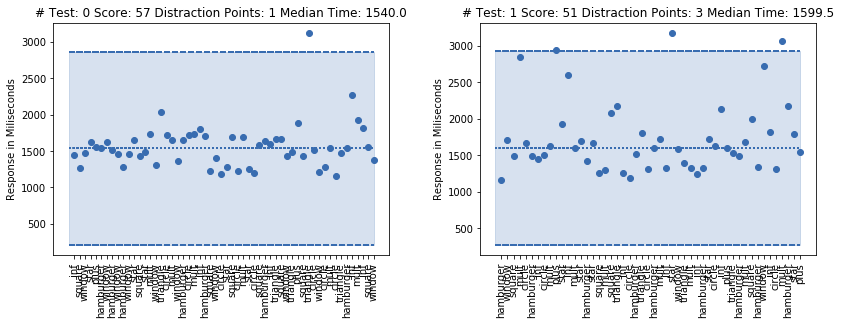

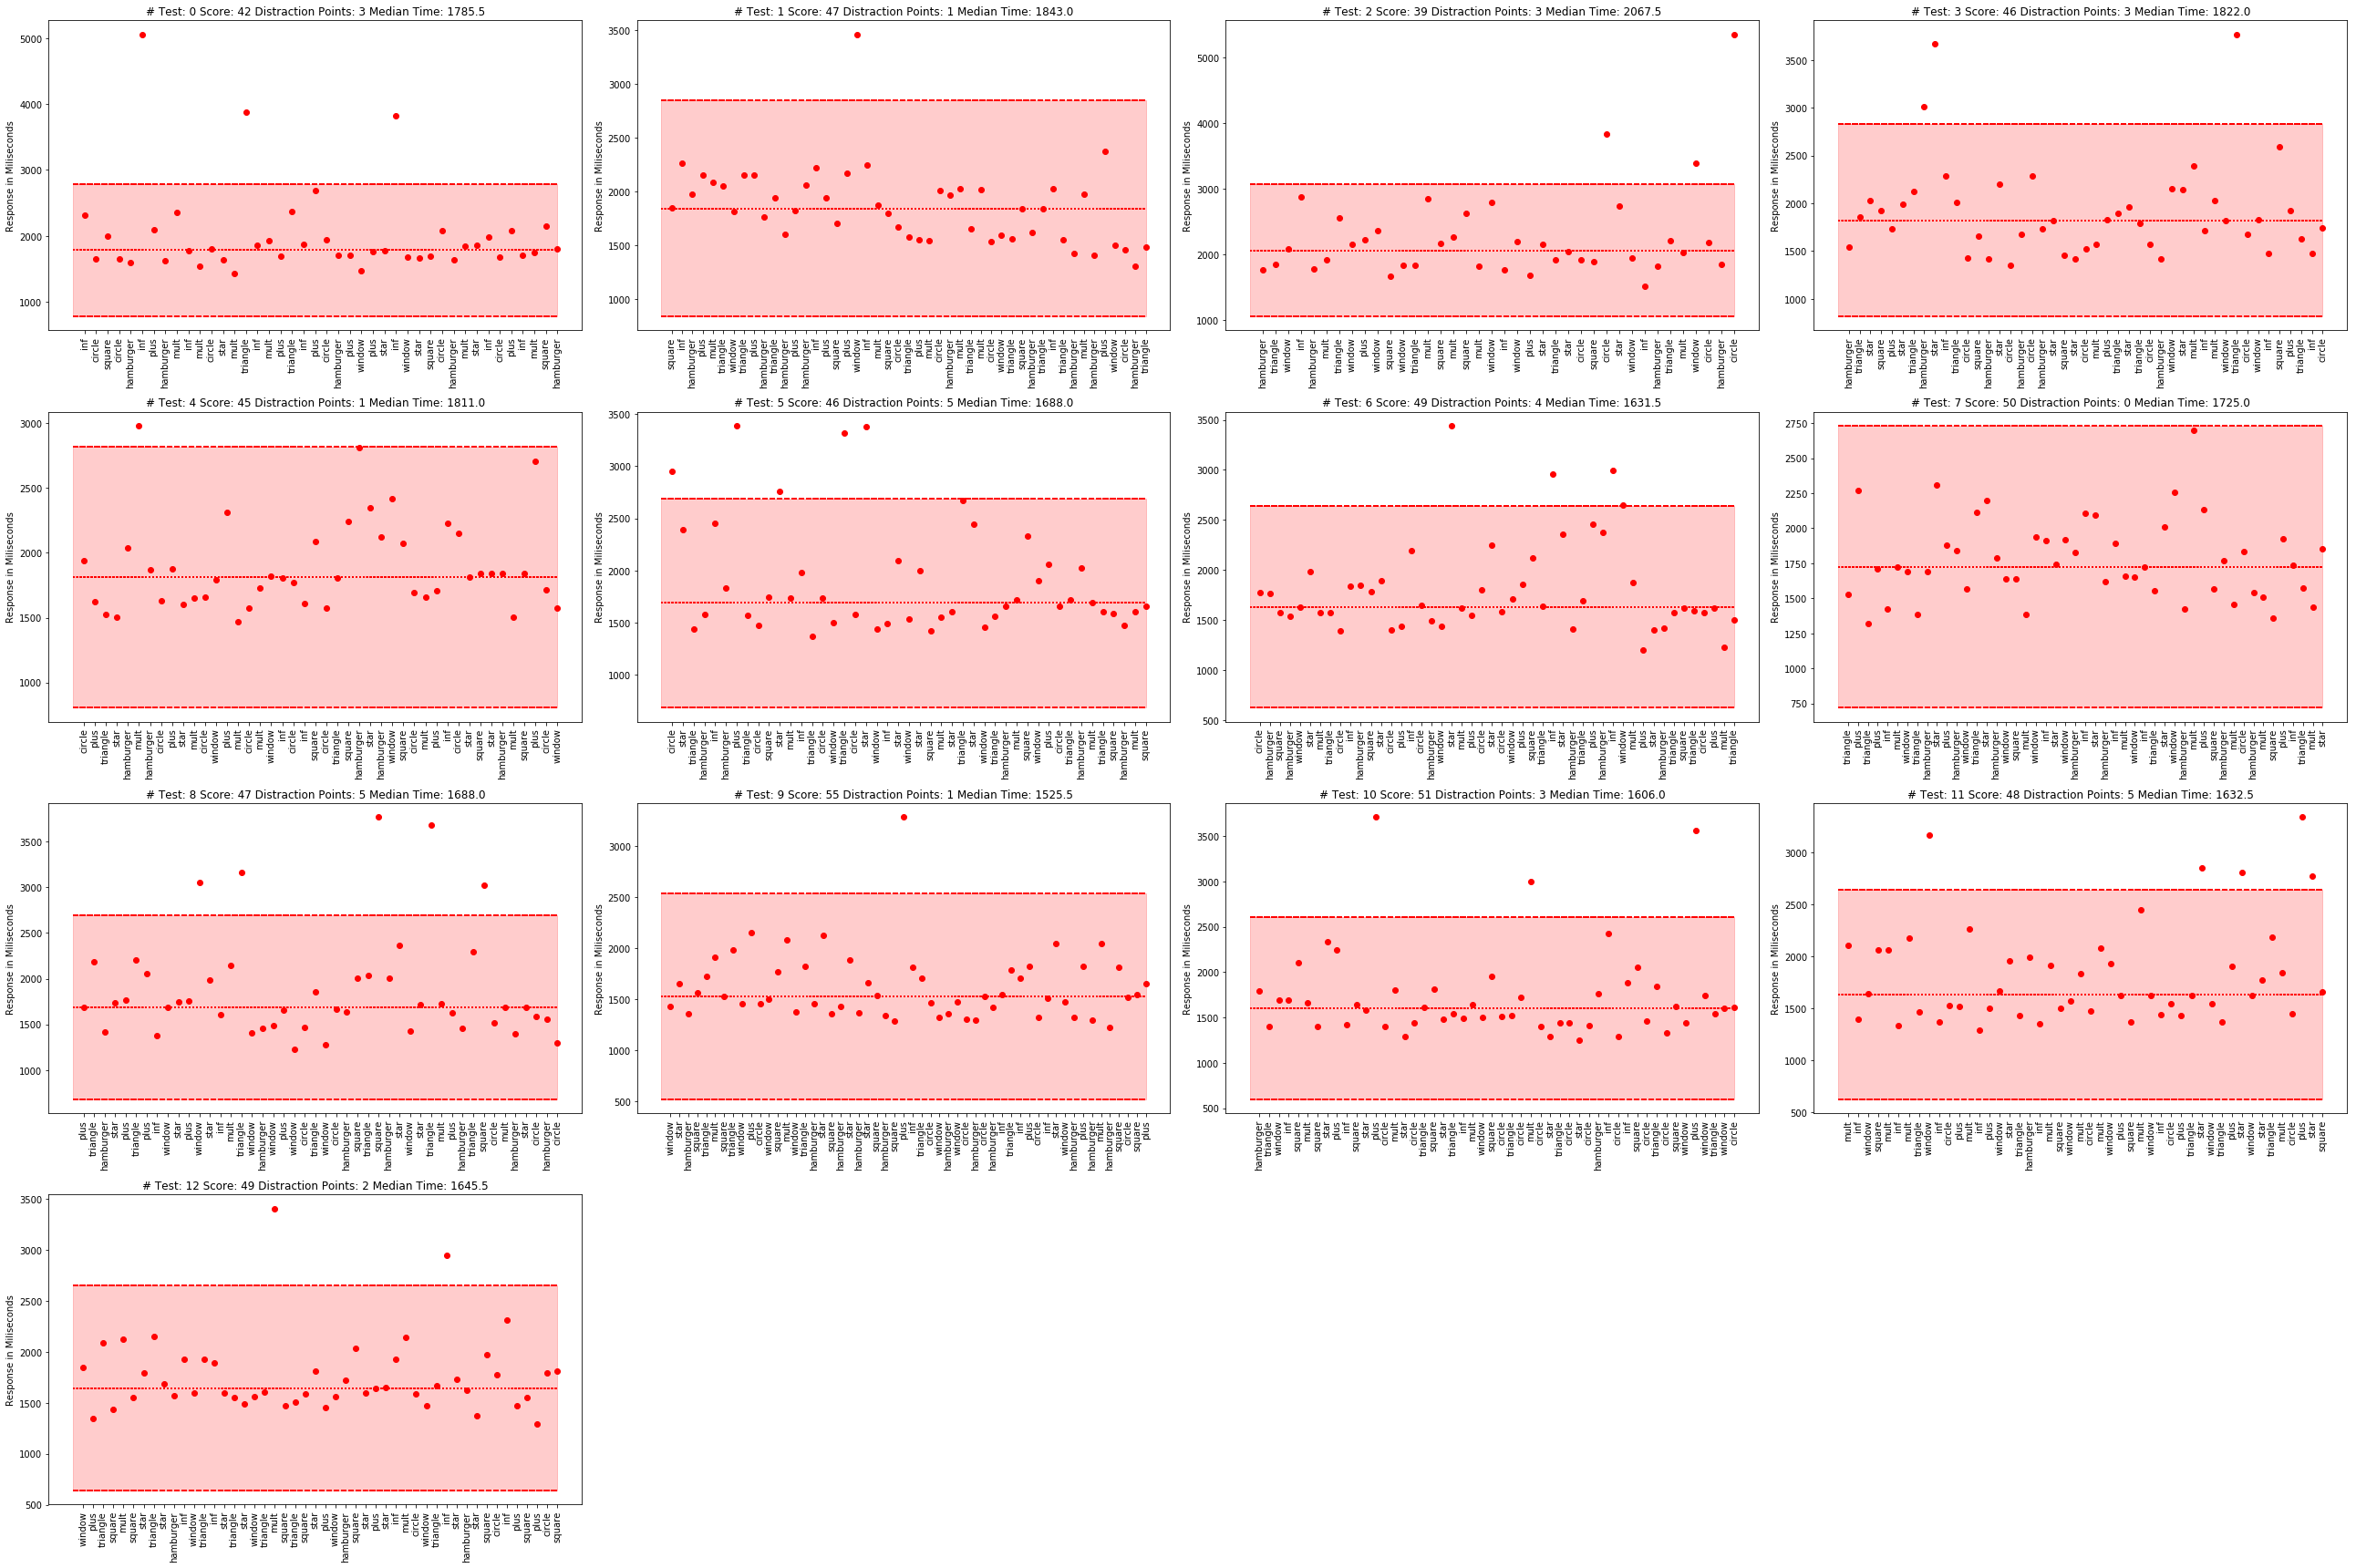

In [19]:
users = list(zip(df_measures_users['userId'], [color_ms if ms==1 else color_hc for ms in df_measures_users['ms']]))
for user in users:
    df_user = df_symbols[df_symbols['userId']==user[0]]
    stamps = df_user['timestamp'].unique()
    if len(stamps) <= 2**2: 
        plot_size =  (2,2); fig_size = (12*1,8*1)
    elif len(stamps) <=3**2: 
        plot_size = (3,3); fig_size = (12*2,8*2)
    elif len(stamps) <=4**2: 
        plot_size = (4,4); fig_size = (12*3,8*3)
    elif len(stamps) <=5**2: 
        plot_size = (5,5); fig_size = (12*4,8*4)
    else: 
        plot_size = (10,10); fig_size = (3*2**10, 2**10)
    plt.figure(figsize=(fig_size[0], fig_size[1]))
    for idx, i in enumerate(range(len(stamps))):
        plt.subplot(plot_size[0],plot_size[1],idx+1)
        df_user_ts = df_user[df_user['timestamp']==stamps[i]]
        plt.scatter(df_user_ts['trial'], df_user_ts['response_ms'], color=user[1])
        plt.hlines(y=df_user_ts['sup_line'], 
                   xmin=0, xmax=max(df_user_ts['trial']), linestyles='--', color=user[1])
        plt.hlines(y=df_user_ts['inf_line'], 
                   xmin=0, xmax=max(df_user_ts['trial']), linestyles='--', color=user[1])
        plt.hlines(y=df_user_ts['response_ms_med'], 
                   xmin=0, xmax=max(df_user_ts['trial']), linestyles=':', color=user[1])
        plt.fill_between(range(len(df_user_ts['trial'])+1), 
                         df_user_ts['sup_line'].mean(), df_user_ts['inf_line'].mean(), color=user[1], alpha=0.2)
        plt.xticks(df_user_ts['trial'], df_user_ts['symbol'], rotation=90)
        plt.ylabel('Response in Miliseconds')
        grouped = df_symbols.groupby(['userId','timestamp'])['distract_points'].sum().reset_index()
        distractions = grouped[(grouped['userId']==user[0]) &
                                    (grouped['timestamp']==stamps[i])]['distract_points'].values
        plt.title('# Test: '+str(idx)+' Score: '+str(
            max(df_user_ts['correct.answers']))+' Distraction Points: '+str(
            distractions[0])+' Median Time: '+str(df_user_ts['response_ms_med'].mean()))

    plt.tight_layout()